The third edition of *Think Stats* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

## The Binomial Distribution

As a first example, we'll consider the sport of skeet shooting, in which competitors use shotguns to shoot clay disks that are thrown into the air.
In international competition, including the Olympics, there are five rounds with 25 targets per round, with additional rounds as needed to determine a winner.

As a model of a skeet-shooting competition, suppose that every participant has the same probability, `p`, of hitting every target.
Of course, this model is a simplification -- in reality, some competitors have a higher probability than others, and even for a single competitor, it might vary from one attempt to the next.
But even if it is not realistic, this model makes some surprisingly accurate predictions, as we'll see.

To simulate the model, I'll use the following function, which takes the number of targets, `n`, and the probability of hitting each one, `p`, and returns a sequence of 1s and 0s to indicate hits and misses.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkStats/blob/v3/nb/chap05.ipynb).

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

Downloaded thinkstats.py


In [3]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.8.0-py3-none-any.whl size=12556 sha256=e22225856ed2cdf41a0e5a86ea5659e00cde02f1fbd287b8a05c2a874273214c
  Stored in directory: /root/.cache/pip/wheels/ca/a9/1f/90c7a8a37ac37ff0fa0a27b2152f9b24be8910448ab93992f8
Successfully built empiricaldist


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

In [5]:
def flip(n, p):
    choices = [1, 0]
    probs = [p, 1 - p]
    return np.random.choice(choices, n, p=probs)

Here's an example that simulates a round of 25 targets where the probability of hitting each one is 90%.

In [6]:
# Seed the random number generator so we get the same results every time
np.random.seed(1)

In [7]:
flip(25, 0.9)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1])

If we generate a longer sequence and compute the `Pmf` of the results, we can confirm that the proportions of 1s and 0s are correct, at least approximately.

In [8]:
from empiricaldist import Pmf

seq = flip(1000, 0.9)
pmf = Pmf.from_seq(seq)
pmf

,
0,0.101
1,0.899


Now we can use `flip` to simulate a round of skeet shooting and return the number of hits.

In [9]:
def simulate_round(n, p):
    seq = flip(n, p)
    return seq.sum()

In a large competition, suppose 200 competitors shoot 5 rounds each, all with the same probability of hitting the target, `p=0.9`.
We can simulate a competition like that by calling `simulate_round` 1000 times.

In [10]:
n = 25
p = 0.9
results_sim = [simulate_round(n, p) for i in range(1000)]

The average score is close to `22.5`, which is the product of `n` and `p`.

In [11]:
np.mean(results_sim), n * p

(22.522, 22.5)

Here's what the distribution of the results looks like.

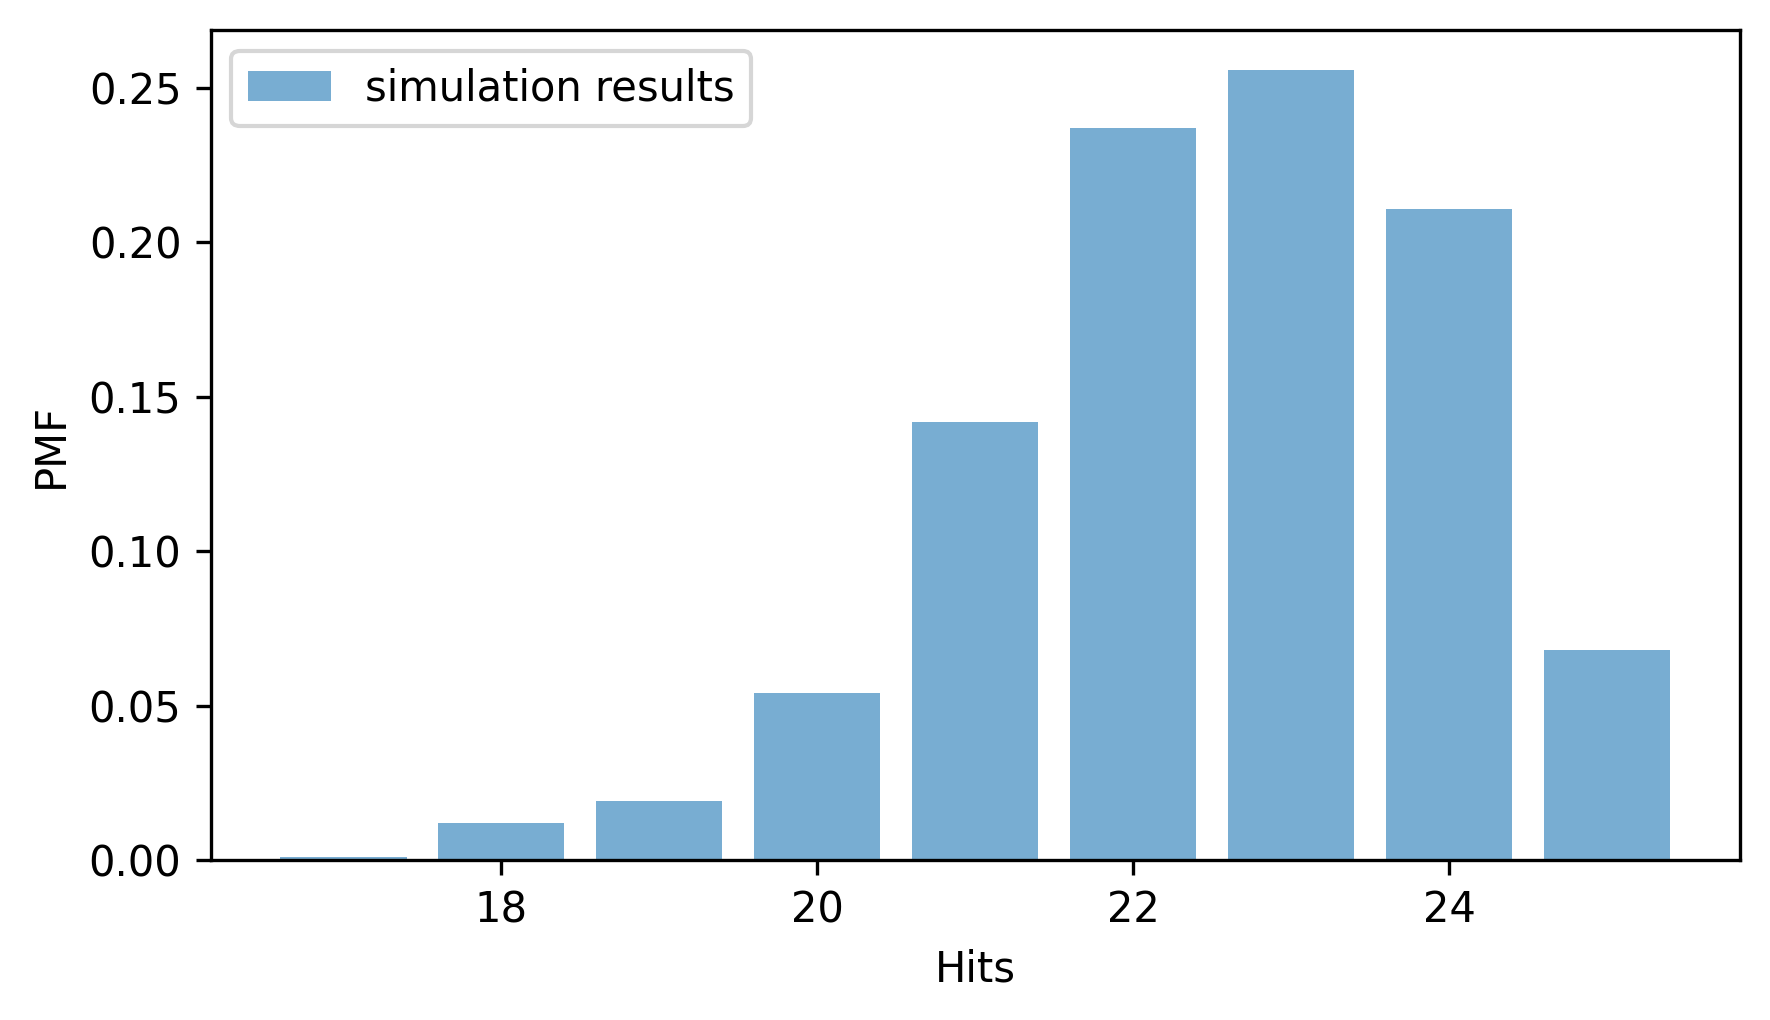

In [12]:
from empiricaldist import Pmf

pmf_sim = Pmf.from_seq(results_sim, name="simulation results")

pmf_sim.bar(alpha=0.6)
decorate(xlabel="Hits", ylabel="PMF")

The peak is near the mean, and the distribution is skewed to the left.

Instead of running a simulation, we could have predicted this distribution.
Mathematically, the distribution of these outcomes follows a **binomial distribution**, which has a PMF that is easy to compute.

In [13]:
from scipy.special import comb


def binomial_pmf(k, n, p):
    return comb(n, k) * (p**k) * ((1 - p) ** (n - k))

In [14]:
p =0.9

SciPy provides the `comb` function, which computes the number of combinations of `n` things taken `k` at a time, often pronounced "n choose k".

`binomial_pmf` computes the probability of getting `k` hits out of `n` attempts, given `p`.
If we call this function with a range of `k` values, we can make a `Pmf` that represents the distribution of the outcomes.

In [15]:
ks = np.arange(1, n + 1)
ps = binomial_pmf(ks, n, p)
pmf_binom = Pmf(ps, ks, name="binomial model")

In [16]:
pmf_binom

,binomial model
1,2.250000e-23
2,2.430000e-21
3,1.676700e-19
4,8.299665e-18
5,3.137273e-16
6,9.411820e-15
7,2.299173e-13
8,4.655826e-12
9,7.914904e-11
10,1.139746e-09


And here's what it looks like compared to the simulation results.

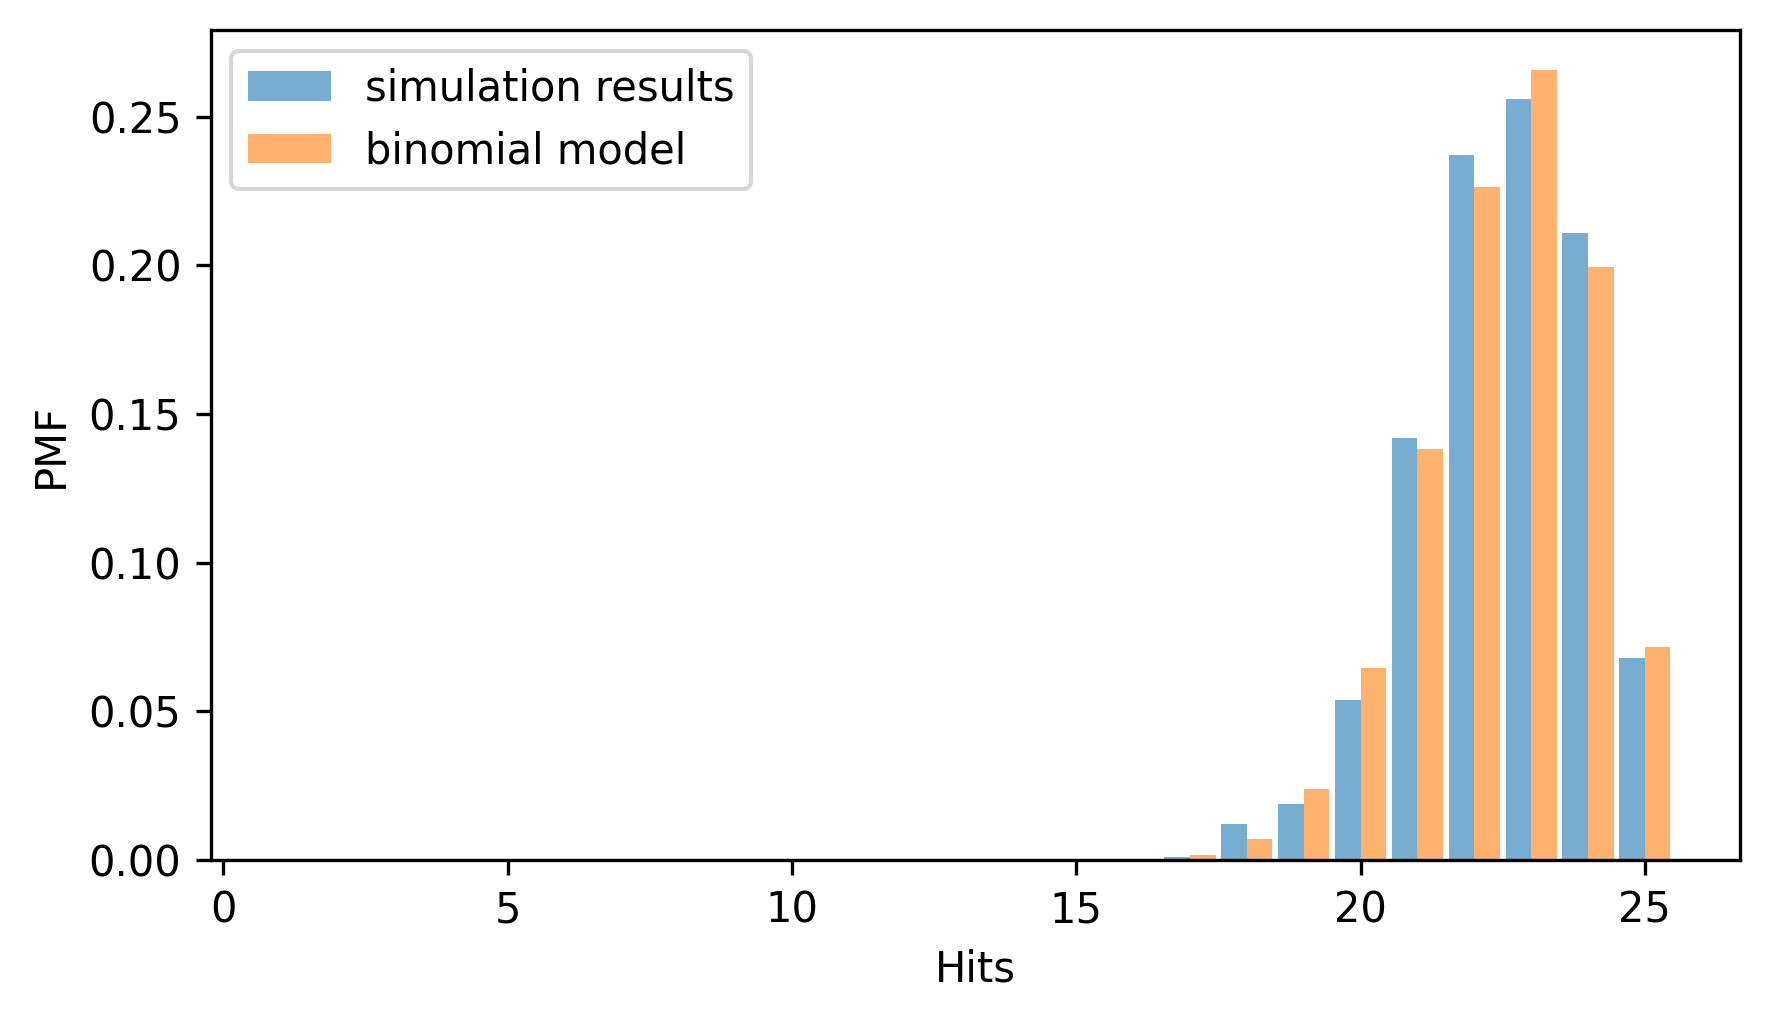

In [17]:
from thinkstats import two_bar_plots

two_bar_plots(pmf_sim, pmf_binom)
decorate(xlabel="Hits", ylabel="PMF")

They are similar, with small differences because of random variation in the simulation results.
This agreement should not be surprising, because the simulation and the model are based on the same assumptions -- particularly the assumption that every attempt has the same probability of success.
A stronger test of a model is how it compares to real data.

From the Wikipedia page for the men's skeet shooting competition at the 2020 Summer Olympics, we can extract a table that shows the results for the qualification rounds.
Instructions for downloading the data are in the notebook for this chapter.

Downloaded from <https://en.wikipedia.org/wiki/Shooting_at_the_2020_Summer_Olympics_–_Men's_skeet> on July 15, 2024.

In [18]:
filename = "Shooting_at_the_2020_Summer_Olympics_Mens_skeet"

In [19]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/" + filename)

Downloaded Shooting_at_the_2020_Summer_Olympics_Mens_skeet


In [20]:
tables = pd.read_html(filename)
table = tables[6]
table.head()

,Rank,Athlete,Country,1,2,3,4,5,Total[3],Shoot-off,Notes
0,1,Éric Delaunay,France,25,25,25,24,25,124,+6,"Q, OR"
1,2,Tammaro Cassandro,Italy,24,25,25,25,25,124,+5,"Q, OR"
2,3,Eetu Kallioinen,Finland,25,25,24,25,24,123,NaN,Q
3,4,Vincent Hancock,United States,25,25,25,25,22,122,+8,Q
4,5,Abdullah Al-Rashidi,Kuwait,25,25,24,25,23,122,+7,Q


The table has one row for each competitor, with one column for each of five rounds.
We'll select the columns that contain these results and use the NumPy function `flatten` to put them into a single array.

In [21]:
columns = ["1", "2", "3", "4", "5"]
results = table[columns].values.flatten()

With 30 competitors, we have results from 150 rounds of 25 shots each, with 3750 hits out of a total of 3575 attempts.

In [22]:
total_shots = 25 * len(results)
total_hits = results.sum()
n, total_shots, total_hits

(25, 3750, 3575)

So the overall success rate is 95.3%.

In [23]:
p = total_hits / total_shots
p

0.9533333333333334

Now let's compute a `Pmf` that represents the binomial distribution with `n=25` and the value of `p` we just computed.

In [24]:
ps = binomial_pmf(ks, n, p)
pmf_binom = Pmf(ps, ks, name="binomial model")

And we can compare that to the `Pmf` of the actual results.

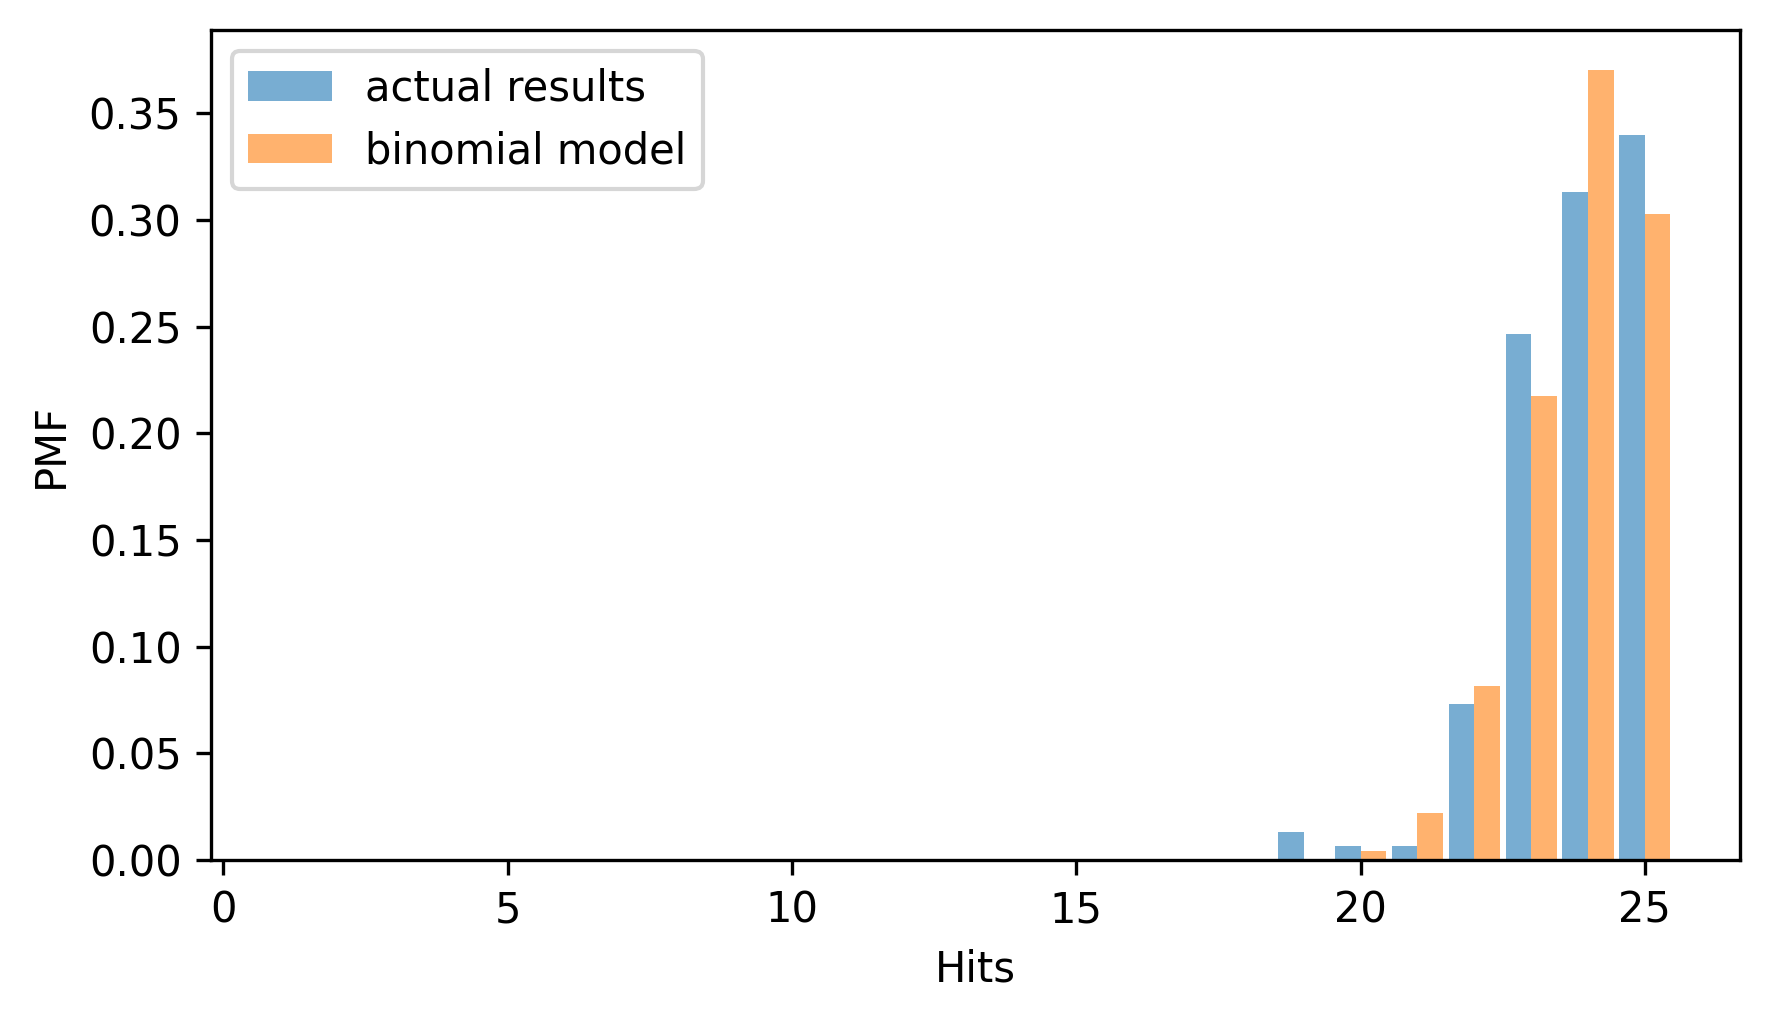

In [25]:
pmf_results = Pmf.from_seq(results, name="actual results")

two_bar_plots(pmf_results, pmf_binom)
decorate(xlabel="Hits", ylabel="PMF")

The binomial model is a good fit for the distribution of the data -- even though it makes the unrealistic assumption that all competitors have the same, unchanging capability.

## The Poisson Distribution

As another example where the outcomes of sports events follow predictable patterns, let's look at the number of goals scored in ice hockey games.

We'll start by simulating a 60-minute game, which is 3600 seconds, assuming that the teams score a total of 6 goals per game, on average, and that the goal-scoring probability, `p`,  is the same during any second.

In [26]:
n = 3600
m = 6
p = m / 3600
p

0.0016666666666666668

Now we can use the following function to simulate `n` seconds and return the total number of goals scored.

In [27]:
def simulate_goals(n, p):
    return flip(n, p).sum()

If we simulate many games, we can confirm that the average number of goals per game is close to 6.

In [28]:
goals = [simulate_goals(n, p) for i in range(1001)]
np.mean(goals)

6.021978021978022

We could use the binomial distribution to model these results, but when `n` is large and `p` is small, the results are also well-modeled by a **Poisson distribution**, which has just one parameter, denoted with the Greek letter λ, which is pronounced "lambda" and represented in code with the variable `lam` (`lambda` is not a legal variable name because it is a Python keyword).
`lam` represents the goal-scoring rate, which is 6 goals per game in the example.

The PMF of the Poisson distribution is easy to compute -- given `lam`, we can use the following function to compute the probability of seeing `k` goals in a game.

In [29]:
from scipy.special import factorial


def poisson_pmf(k, lam):
    """Compute the Poisson PMF.

    k (int or array-like): The number of occurrences
    lam (float): The rate parameter (λ) of the Poisson distribution

    returns: float or ndarray
    """
    return (lam**k) * np.exp(-lam) / factorial(k)

SciPy provides the `factorial` function, which computes the product of the integers from `1` to `k`.

If we call `poisson_pmf` with a range of `k` values, we can make a `Pmf` that represents the distribution of outcomes.

In [30]:
lam = 6
ks = np.arange(20)
ps = poisson_pmf(ks, lam)
pmf_poisson = Pmf(ps, ks, name="Poisson model")

And confirm that the mean of the distribution is close to 6.

In [31]:
pmf_poisson.normalize()
pmf_poisson.mean()

5.999925498375129

The following figure compares the results from the simulation to the Poisson distribution with the same mean.

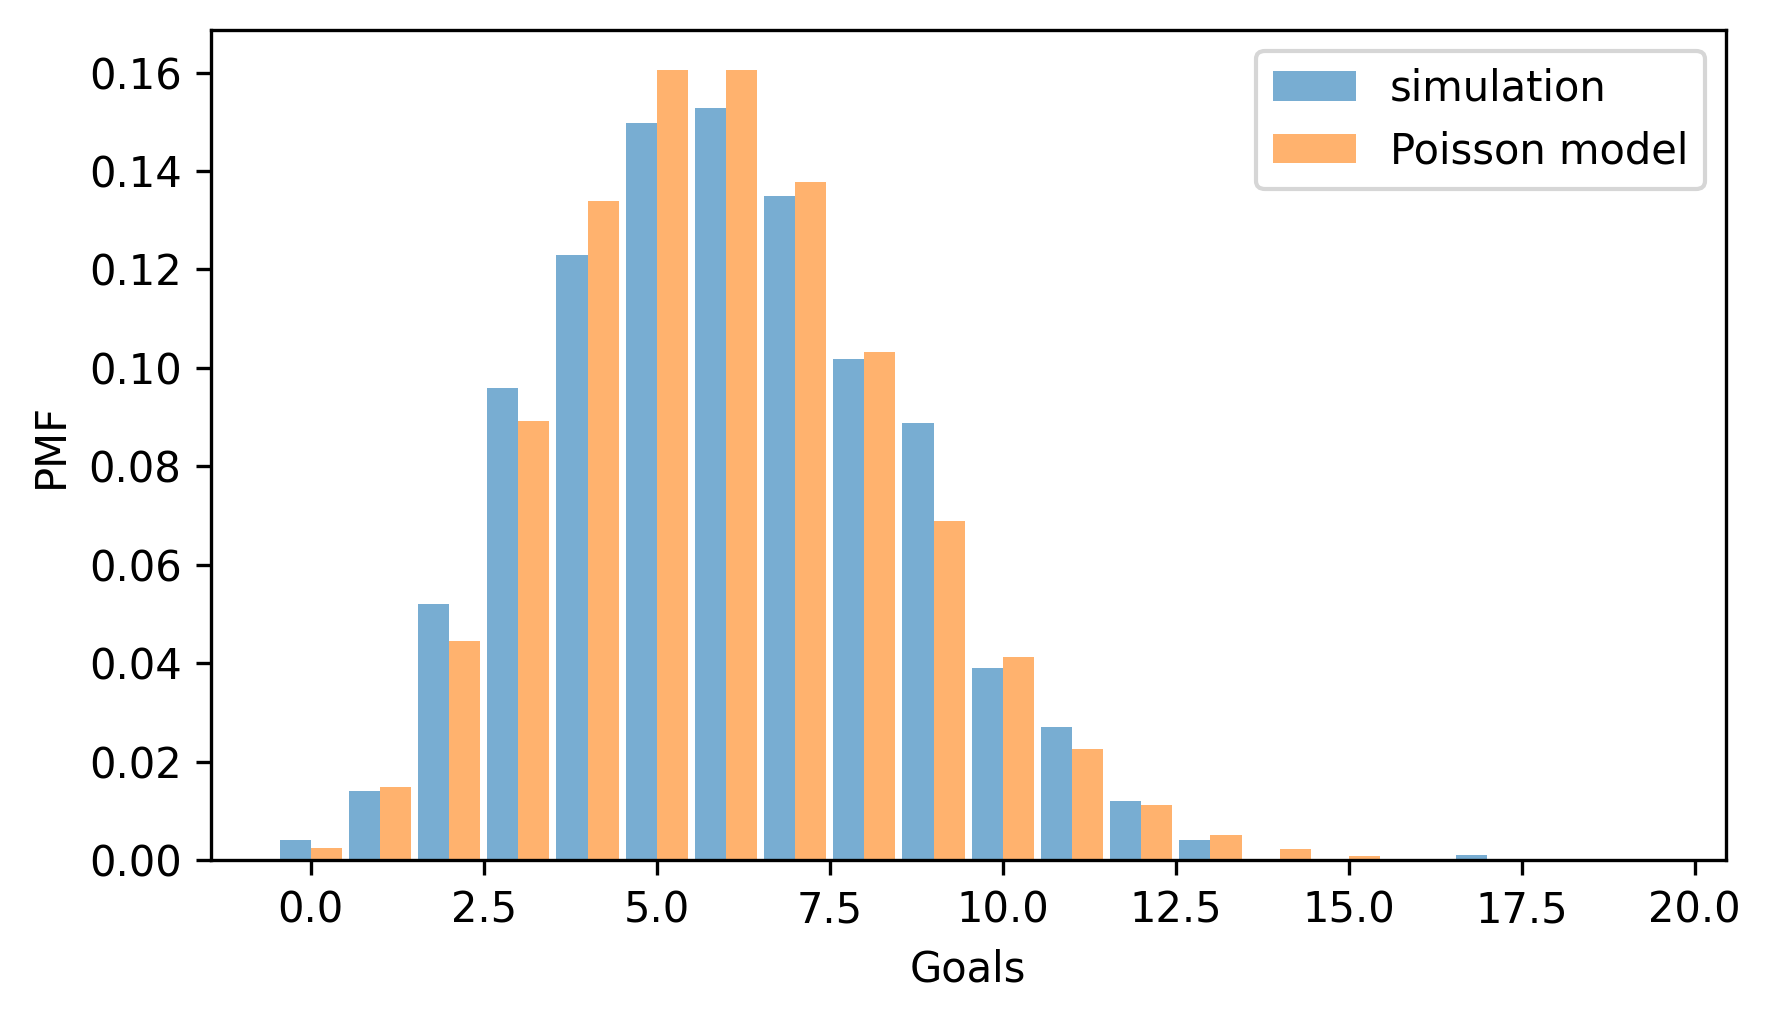

In [32]:
pmf_sim = Pmf.from_seq(goals, name="simulation")

two_bar_plots(pmf_sim, pmf_poisson)
decorate(xlabel="Goals", ylabel="PMF")

<Axes: xlabel='Poisson model'>

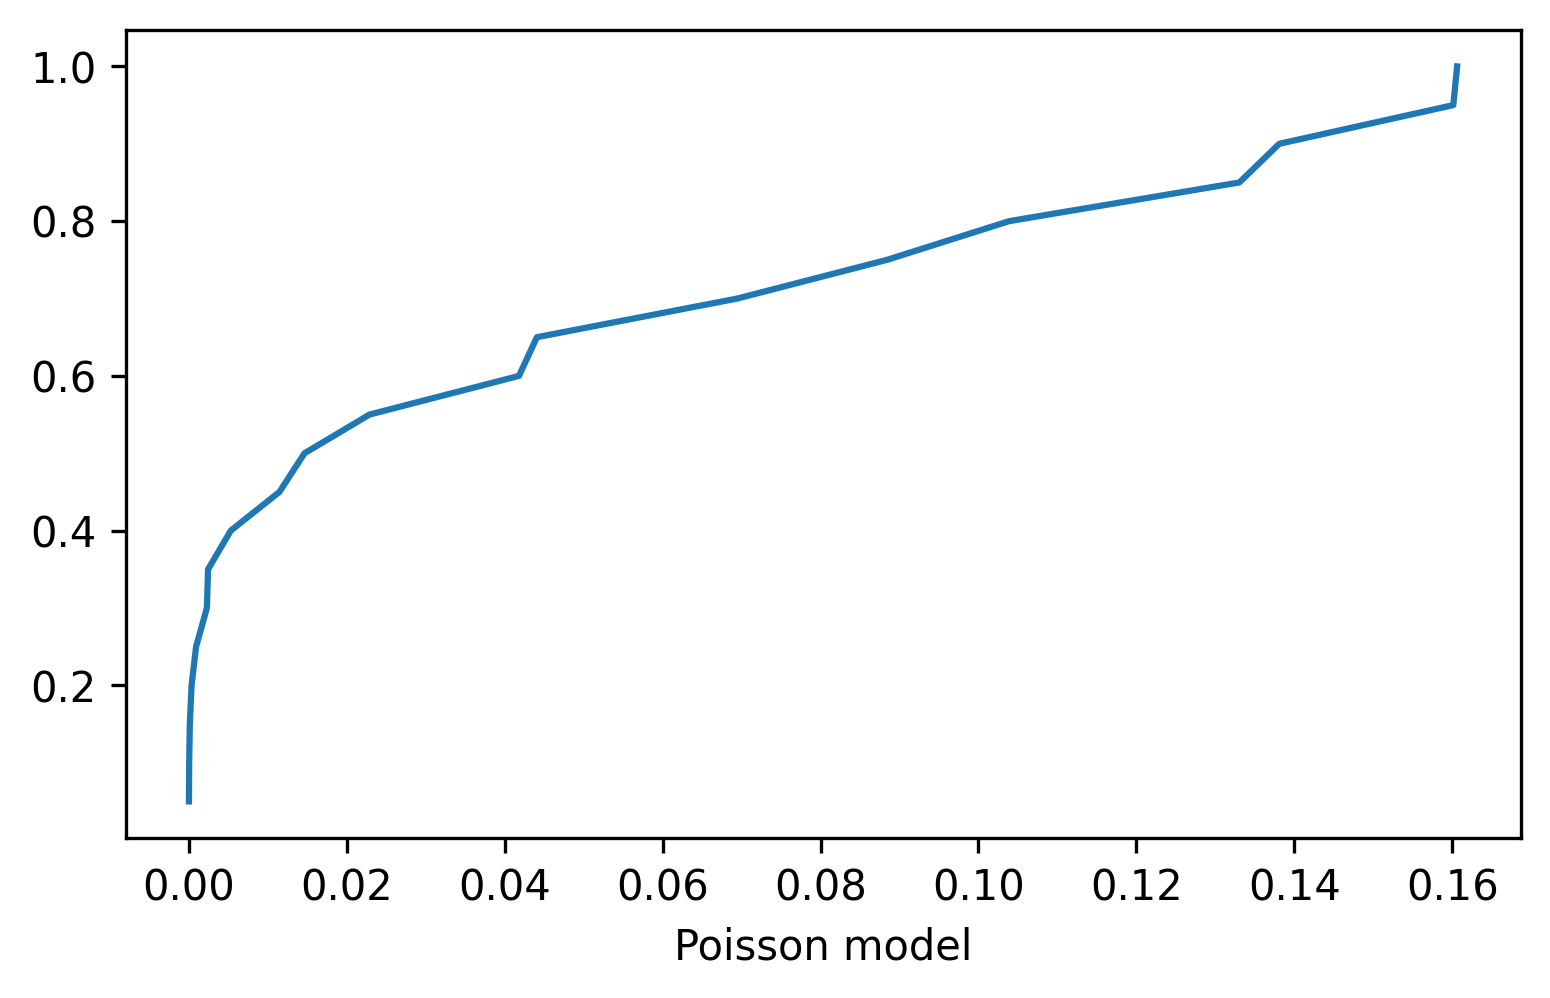

In [115]:
Cdf.from_seq(pmf_poisson).plot()

The distributions are similar except for small differences due to random variation.
That should not be surprising, because the simulation and the Poisson model are based on the same assumption, notably that the probability of scoring a goal is the same during any second of the game.
So the real test is to see how well the model fits real data.

From HockeyReference, I downloaded results of every game of the National Hockey League (NHL) 2023-2024 regular season (not including the playoffs).
I extracted information about goals scored during 60 minutes of regulation play, not including overtime or tie-breaking shootouts.
The results are in an HDF file with one key for each game, and a list of times, in seconds since the beginning of the game, when a goal was scored.
Instructions for downloading the data are in the notebook for this chapter.

Raw data downloaded from <https://www.hockey-reference.com/leagues/NHL_2024_games.html> on July 16, 2024.

In [33]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/nhl_2023_2024.hdf")

Downloaded nhl_2023_2024.hdf


Here's how we read the keys from the file.

In [34]:
filename = "nhl_2023_2024.hdf"

with pd.HDFStore(filename, "r") as store:
    keys = store.keys()

len(keys), keys[0]

(1312, '/202310100PIT')

There were 1312 games during the regular season.
Each key contains the date of the game and a three-letter abbreviation for the home team.
We can use `read_hdf` to look up a key and get the list of times when a goal was scored.

In [35]:
times = pd.read_hdf(filename, key=keys[0])
times

,0
0,424
1,1916
2,2137
3,3005
4,3329
5,3513


In the first game of the season, six goals were scored, the first after 424 seconds of play, the last at after 3513 seconds -- with only 87 seconds left in the game.

In [36]:
3600 - times[5]

87

The following loop reads the results for all games, counts the number of goals in each one, and stores the results in a list.

In [37]:
goals = []

for key in keys:
    times = pd.read_hdf(filename, key=key)
    n = len(times)
    goals.append(n)

The average number of goals per game is just over 6.

In [38]:
lam = np.mean(goals)
lam

6.0182926829268295

We can use `poisson_pmf` to make a `Pmf` that represents a Poisson distribution with the same mean as the data.

In [39]:
ps = poisson_pmf(ks, lam)
pmf_poisson = Pmf(ps, ks, name="Poisson model")

And here's what it looks like compared to the PMF of the data.

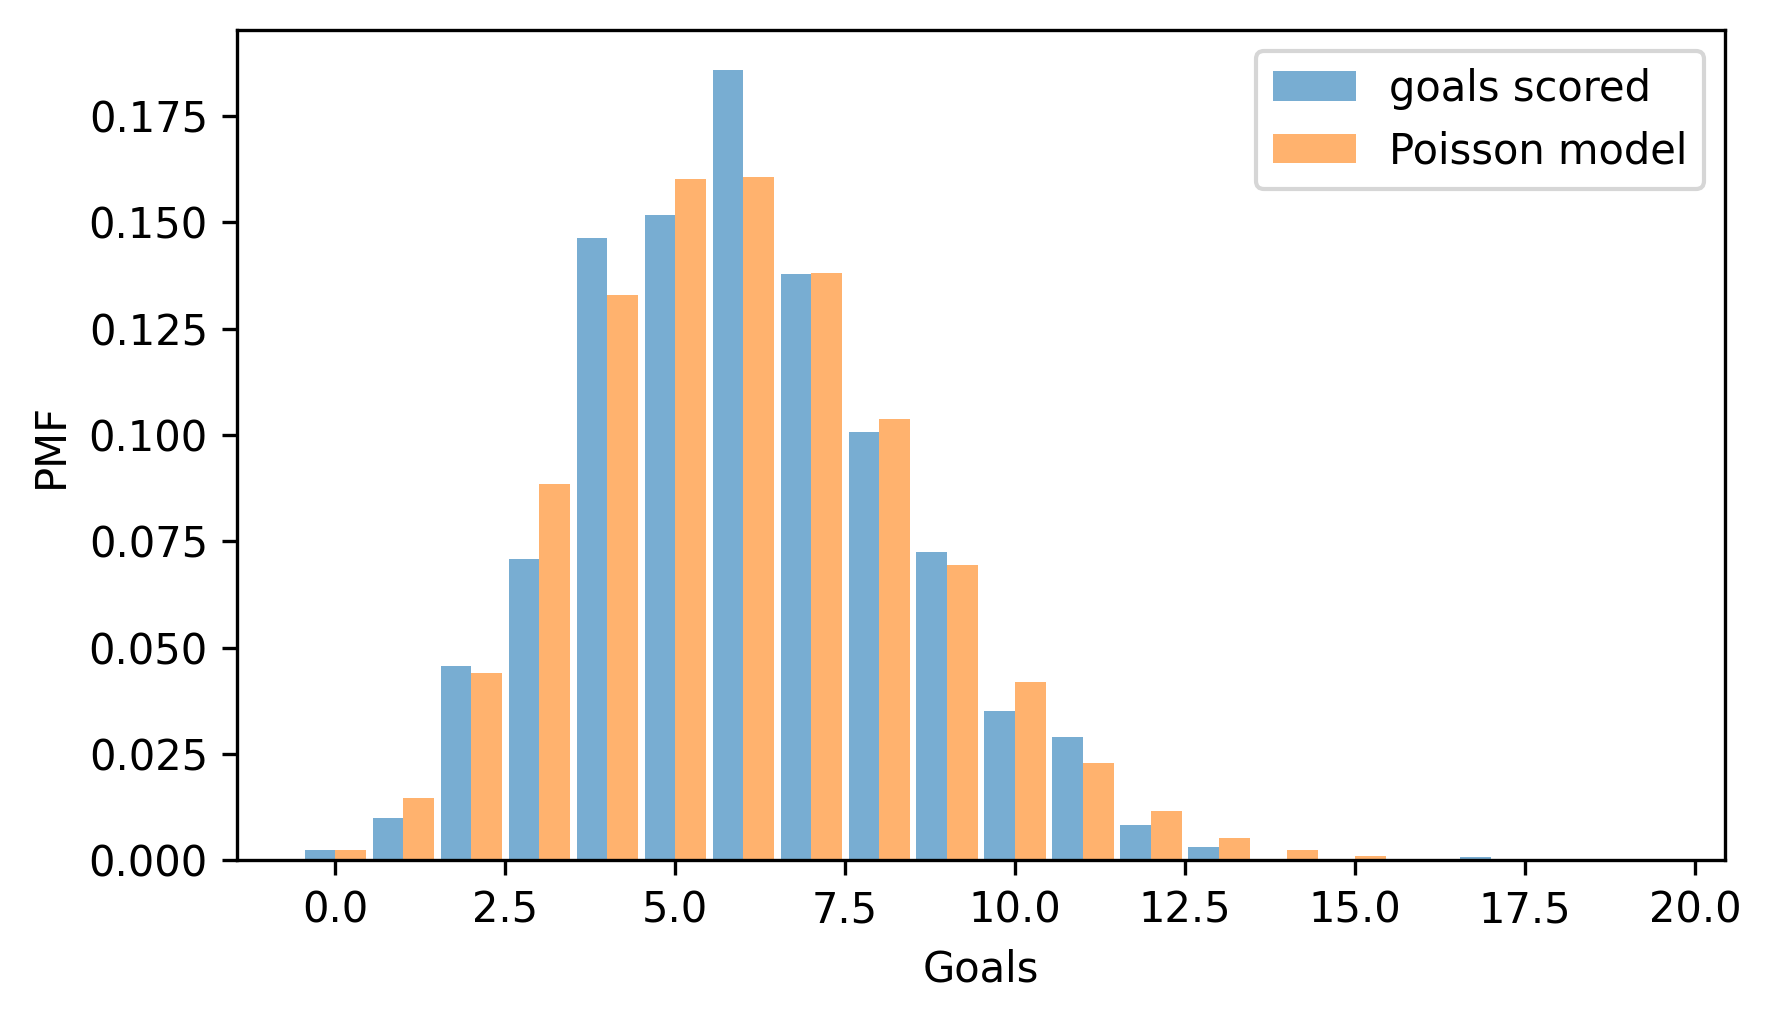

In [40]:
pmf_goals = Pmf.from_seq(goals, name="goals scored")

two_bar_plots(pmf_goals, pmf_poisson)
decorate(xlabel="Goals", ylabel="PMF")

The Poisson distribution fits the data well, which suggests that it is a good model of the goal-scoring process in hockey.

## The Exponential Distribution

In the previous section, we simulated a simple model of a hockey game where a goal has the same probability of being scored during any second of the game.
Under the same model, it turns out, the time until the first goal follows an **exponential distribution**.

To demonstrate, let's assume again that the teams score a total of 6 goals, on average, and compute the probability of a goal during each second.

In [41]:
n = 3600
m = 6
p = m / 3600
p

0.0016666666666666668

The following function simulates `n` seconds and uses `argmax` to find the time of the first goal.

In [42]:
def simulate_first_goal(n, p):
    return flip(n, p).argmax()

This works because the result from `flip` is a sequence of 1s and 0s, so the maximum is almost always 1.
If there is at least one goal in the sequence, `argmax` returns the index of the first.
If there are no goals, it returns 0, but that happens seldom enough that we'll ignore it.

We'll use `simulate_first_goal` to simulate 1001 games and make a list of the times until the first goal.

In [43]:
np.random.seed(3)

In [44]:
first_goal_times = [simulate_first_goal(n, p) for i in range(1001)]
mean = np.mean(first_goal_times)
mean

597.7902097902098

The average time until the first goal is close to 600 seconds, or 10 minutes.
And that makes sense -- if we expect 6 goals per sixty-minute game, we expect one goal every 10 minutes, on average.

When `n` is large and `p` is small, we can show mathematically that the expected time until the first goal follows an exponential distribution.

Because the simulation generates many unique time values, we'll use CDFs to compare distributions, rather than PMFs.
And the CDF of the exponential distribution is easy to compute.

In [45]:
def exponential_cdf(x, lam):
    """Compute the exponential CDF.

    x: float or sequence of floats
    lam: rate parameter

    returns: float or NumPy array of cumulative probability
    """
    return 1 - np.exp(-lam * x)

The parameter, `lam`, is the average number of events per unit of time -- in this example it is goals per second.
We can use the mean of the simulated results to compute lam.

In [46]:
lam = 1 / mean
lam

0.0016728276636563566

If we call this function with a range of time values, we can approximate the distribution of first goal times.
The NumPy function `linspace` creates an array of equally-spaced values; in this example, it computes 201 values from 0 to 3600, including both.

In [47]:
from empiricaldist import Cdf

ts = np.linspace(0, 3600, 201)
ps = exponential_cdf(ts, lam)
cdf_expo = Cdf(ps, ts, name="exponential model")

In [48]:
ts

array([   0.,   18.,   36.,   54.,   72.,   90.,  108.,  126.,  144.,
        162.,  180.,  198.,  216.,  234.,  252.,  270.,  288.,  306.,
        324.,  342.,  360.,  378.,  396.,  414.,  432.,  450.,  468.,
        486.,  504.,  522.,  540.,  558.,  576.,  594.,  612.,  630.,
        648.,  666.,  684.,  702.,  720.,  738.,  756.,  774.,  792.,
        810.,  828.,  846.,  864.,  882.,  900.,  918.,  936.,  954.,
        972.,  990., 1008., 1026., 1044., 1062., 1080., 1098., 1116.,
       1134., 1152., 1170., 1188., 1206., 1224., 1242., 1260., 1278.,
       1296., 1314., 1332., 1350., 1368., 1386., 1404., 1422., 1440.,
       1458., 1476., 1494., 1512., 1530., 1548., 1566., 1584., 1602.,
       1620., 1638., 1656., 1674., 1692., 1710., 1728., 1746., 1764.,
       1782., 1800., 1818., 1836., 1854., 1872., 1890., 1908., 1926.,
       1944., 1962., 1980., 1998., 2016., 2034., 2052., 2070., 2088.,
       2106., 2124., 2142., 2160., 2178., 2196., 2214., 2232., 2250.,
       2268., 2286.,

The following figure compares the simulation results to the exponential distribution we just computed.

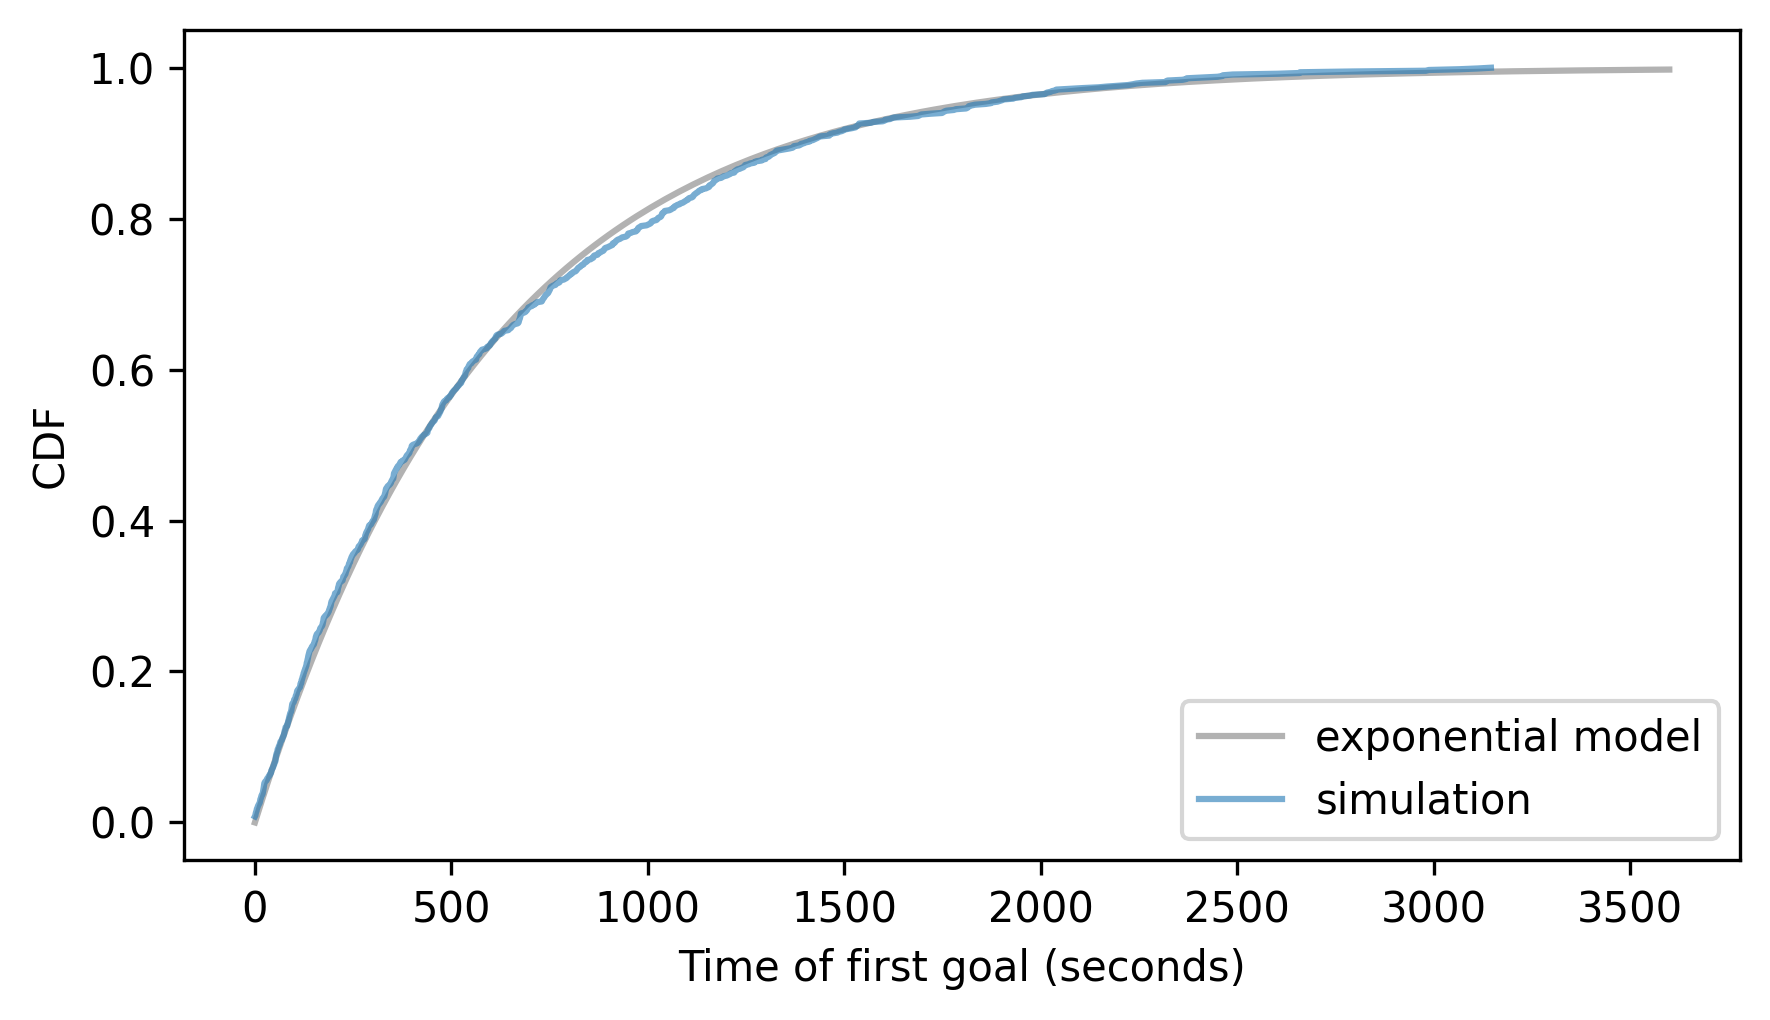

In [49]:
cdf_sim = Cdf.from_seq(first_goal_times, name="simulation")

cdf_expo.plot(alpha=0.6, color="gray")
cdf_sim.plot(alpha=0.6)

decorate(xlabel="Time of first goal (seconds)", ylabel="CDF")

The exponential model fits the results from the simulation very well -- but the real test is to see how it does with real data.

The following loop reads the results for all games, gets the time of the first goal, and stores the result in a list.
If no goals were scored, it adds `nan` to the list.

In [50]:
filename = "nhl_2023_2024.hdf"

with pd.HDFStore(filename, "r") as store:
    keys = store.keys()

In [51]:
firsts = []

for key in keys:
    times = pd.read_hdf(filename, key=key)
    if len(times) > 0:
        firsts.append(times[0])
    else:
        firsts.append(np.nan)

To estimate the goal-scoring rate, we can use `nanmean`, which computes the mean of the times, ignoring `nan` values.

In [52]:
lam = 1 / np.nanmean(firsts)
lam

0.0015121567467720825

Now we can compute the CDF of an exponential distribution with the same goal-scoring rate as the data.

In [53]:
ps = exponential_cdf(ts, lam)
cdf_expo = Cdf(ps, ts, name="exponential model")

To compute the CDF of the data, we'll use the `dropna=False` argument, which includes `nan` values at the end.

In [54]:
cdf_firsts = Cdf.from_seq(firsts, name="data", dropna=False)
cdf_firsts.tail()

,data
3286.0,0.996951
3581.0,0.997713
NaN,1.000000


The following figure compares the exponential distribution to the distribution of the data.

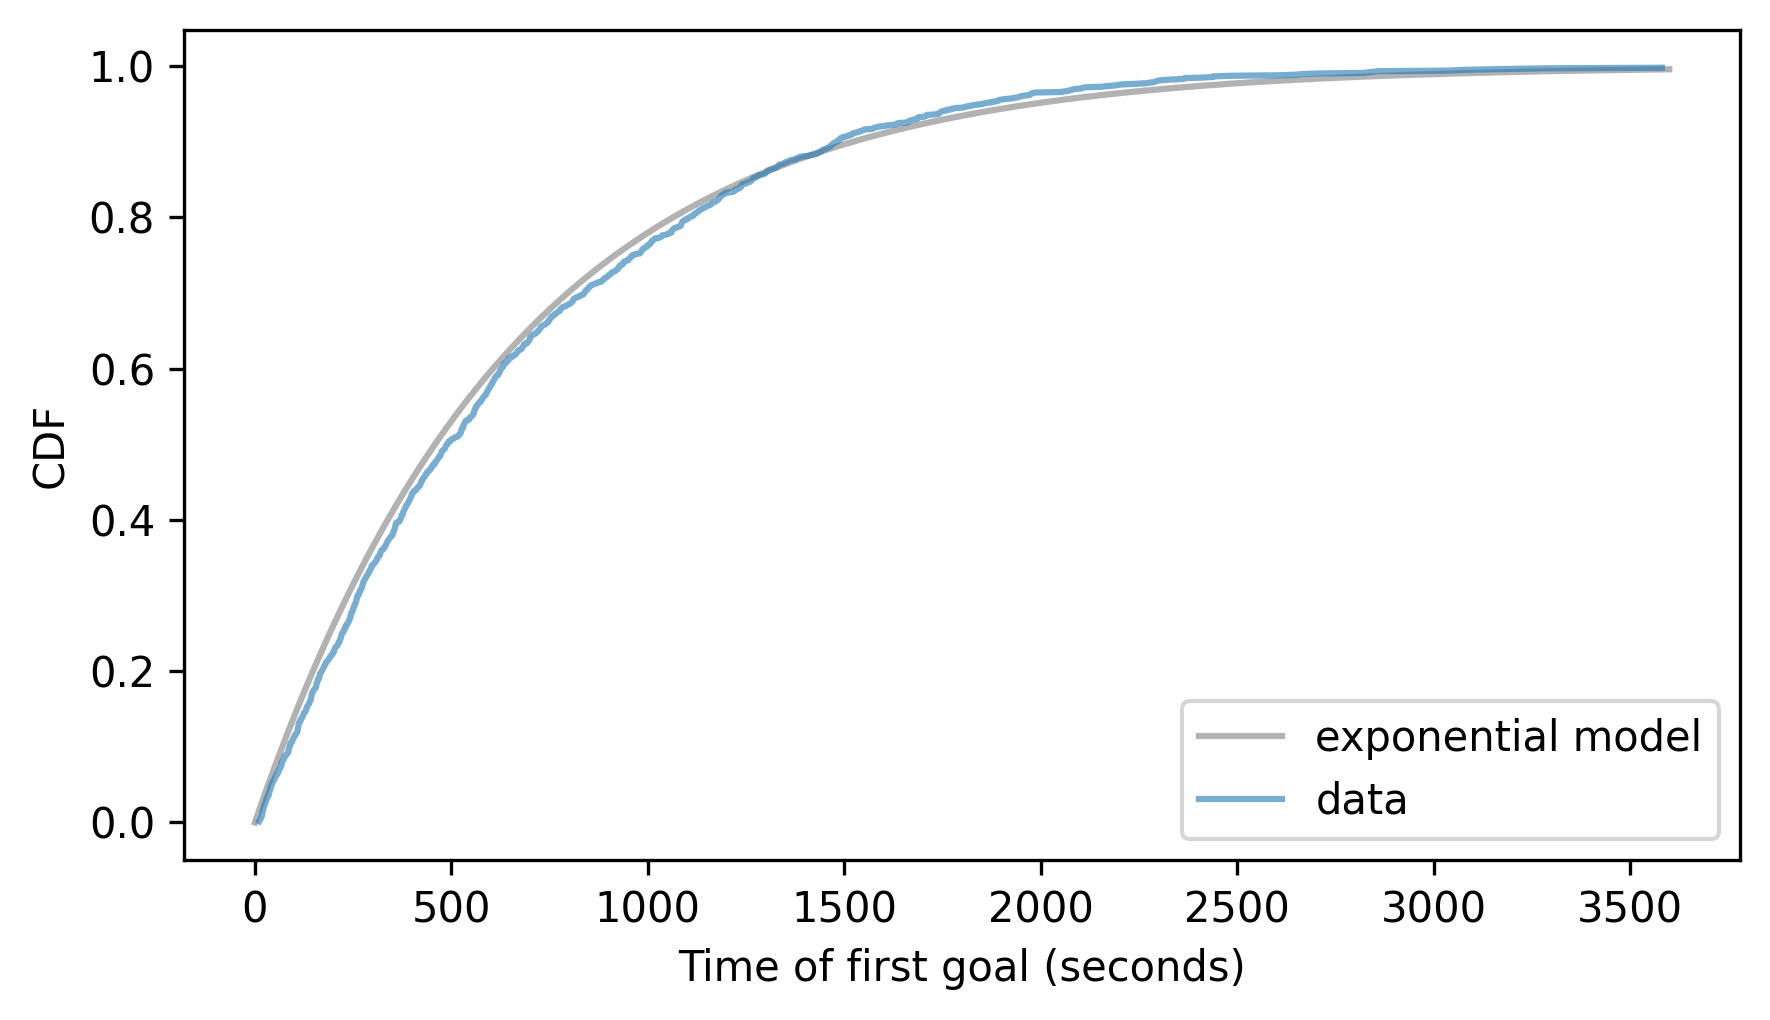

In [55]:
cdf_expo.plot(alpha=0.6, color="gray")
cdf_firsts.plot(alpha=0.6)

decorate(xlabel="Time of first goal (seconds)", ylabel="CDF")

The data deviate from the model in some places -- it looks like there are fewer goals in the first 1000 seconds than the model predicts.
But still, the model fits the data well.

The underlying assumption of these models -- the Poisson model of goals and the exponential model of times -- is that a goal is equally likely during any second of a game.
If you ask a hockey fan whether that's true, they would say no, and they would be right -- the real world violates assumptions like these in many ways.
Nevertheless, theoretical distributions often fit real data remarkably well.

(section_normal)=
## The Normal Distribution

Many things we measure in the real world follow a **normal distribution**, also known as a Gaussian distribution or a "bell curve".
To see where these distributions come from, let's consider a model of the way giant pumpkins grow.
Suppose that each day, a pumpkin gains 1 pound if the weather is bad, 2 pounds if the weather is fair, and 3 pounds if the weather is good.
And suppose the weather each day is bad, fair, or good with the same probability.

We can use the following function to simulate this model for `n` days and return the total of the weight gains.

In [56]:
def simulate_growth(n):
    choices = [1, 2, 3]
    gains = np.random.choice(choices, n)
    return gains.sum()

NumPy's `random` module provides a `choice` function that generates an array of `n` random selections from a sequence of values, `choices` in this example.

Now suppose 1001 people grow giant pumpkins in different places with different weather.
If we simulate the growth process for 100 days, we get a list of 1001 weights.

In [57]:
sim_weights = [simulate_growth(100) for i in range(1001)]
m, s = np.mean(sim_weights), np.std(sim_weights)
m, s

(199.37062937062936, 8.388630840376777)

The mean is close to 200 pounds and the standard deviation is about 8 pounds.
To see whether the weights follow a normal distribution, we'll use the following function, which takes a sample and makes a `Cdf` that represents a normal distribution with the same mean and standard deviation as the sample, evaluated over the range from 4 standard deviations below the mean to 4 standard deviations above.

In [58]:
from scipy.stats import norm


def make_normal_model(data):
    m, s = np.mean(data), np.std(data)
    low, high = m - 4 * s, m + 4 * s
    qs = np.linspace(low, high, 201)
    ps = norm.cdf(qs, m, s)
    return Cdf(ps, qs, name="normal model")

Here's how we use it.

In [59]:
cdf_model = make_normal_model(sim_weights)

Now we can make a `Cdf` that represents the distribution of the simulation results.

In [60]:
cdf_sim_weights = Cdf.from_seq(sim_weights, name="simulation")

We'll use the following function to compare the distributions.
`cdf_model` and `cdf_data` are `Cdf` objects.
`xlabel` is a string, and `options` is a dictionary of options that controls the way `cdf_data` is plotted.

In [61]:
def two_cdf_plots(cdf_model, cdf_data, xlabel="", **options):
    cdf_model.plot(alpha=0.6, color="gray")
    cdf_data.plot(alpha=0.6, **options)
    decorate(xlabel=xlabel, ylabel="CDF")

And here are the results.

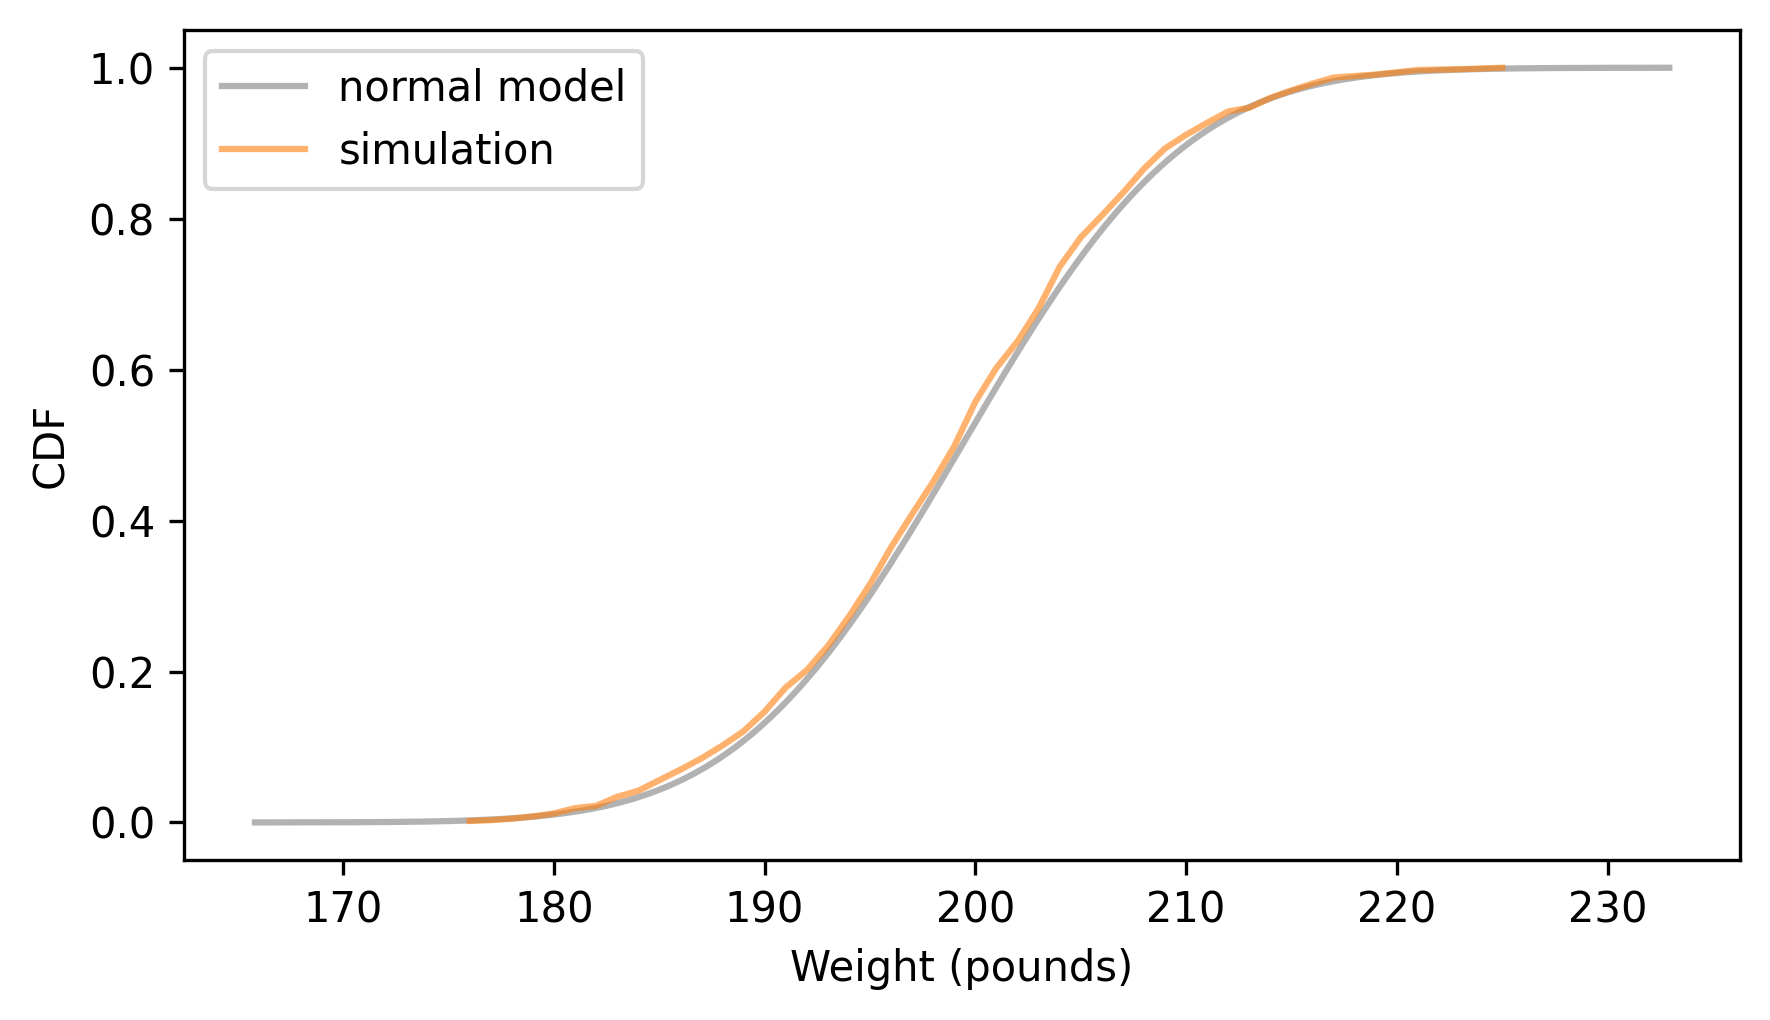

In [62]:
two_cdf_plots(cdf_model, cdf_sim_weights, color="C1", xlabel="Weight (pounds)")

The normal model fits the distribution of the weights very well.
In general, when we add up enough random factors, the sum tends to follow a normal distribution.
That's a consequence of the Central Limit Theorem, which we'll come back to in [Chapter 14](section_central_limit_theorem).

But first let's see how well the normal distribution fits real data.
As an example, we'll look at the distribution of birth weights in the National Survey of Family Growth (NSFG).
We can use `read_fem_preg` to read the data, then select the `totalwgt_lb` column, which records birth weights in pounds.

The following cells download the data files and install `statadict`, which we need to read the data.

In [63]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dat.gz")

Downloaded nsfg.py
Downloaded 2002FemPreg.dct
Downloaded 2002FemPreg.dat.gz


In [64]:
try:
    import statadict
except ImportError:
    !pip install statadict

In [65]:
import nsfg

preg = nsfg.read_fem_preg()
birth_weights = preg["totalwgt_lb"].dropna()

The average of the birth weights is about 7.27 pounds, and the standard deviation is 1.4 pounds, but as we've seen, there are some outliers in this dataset that are probably errors.

In [66]:
m, s = np.mean(birth_weights), np.std(birth_weights)
m, s

(7.265628457623368, 1.4082155338406195)

To reduce the effect of the outliers on the estimated mean and standard deviation, we'll use the SciPy function `trimboth` to remove the highest and lowest values.

In [67]:
from scipy.stats import trimboth

trimmed = trimboth(birth_weights, 0.01)
m, s = np.mean(trimmed), np.std(trimmed)
m, s

(7.280883100022579, 1.2430657948614345)

With the trimmed data, the mean is a little lower and the standard deviation is substantially lower.
We'll use the trimmed data to make a normal model.

In [68]:
cdf_model = make_normal_model(trimmed)

And compare it to the `Cdf` of the data.

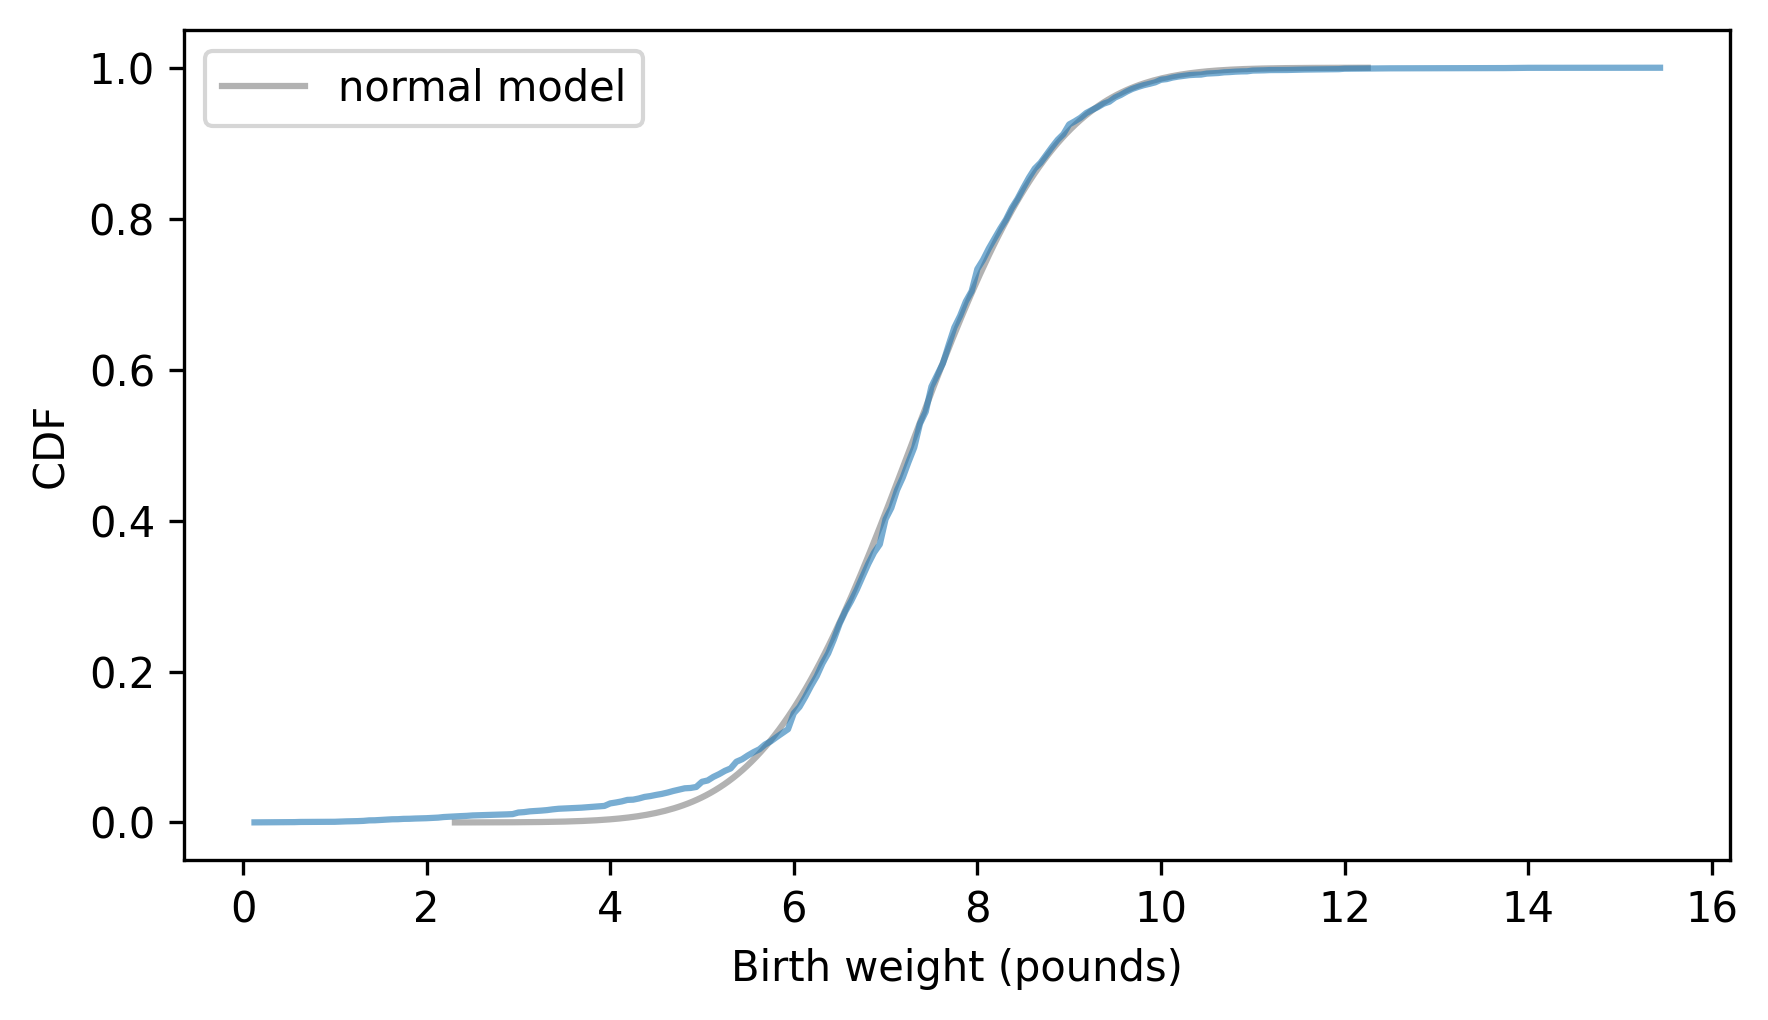

In [69]:
cdf_birth_weight = Cdf.from_seq(birth_weights)

two_cdf_plots(cdf_model, cdf_birth_weight, xlabel="Birth weight (pounds)")

The normal model fits the data well except below 5 pounds, where the distribution of the data is to the left of the model -- that is, the lightest babies are lighter than we'd expect in a normal distribution.
The real world is more complicated than simple mathematical models.

(section_lognormal_distribution)=
## The Lognormal Distribution

In the previous section, we simulated pumpkin growth under the assumption that pumpkins grow 1-3 pounds per day, depending on the weather.
Instead, let's suppose their growth is proportional to their current weight, so big pumpkins gain more weight per day than small pumpkins -- which is probably more realistic.

The following function simulates this kind of proportional growth, where a pumpkin gains 3% of its weight if the weather is bad, 5% if the weather is fair, and 7% if the weather is good.
Again, we'll assume that the weather is bad, fair, or good on any given day with equal probability.

In [70]:
def simulate_proportionate_growth(n):
    choices = [1.03, 1.05, 1.07]
    gains = np.random.choice(choices, n)
    return gains.prod()

If a pumpkin gains 3% of its weight, the final weight is the product of the initial weight and the factor 1.03.
So we can compute the weight after 100 days by choosing random factors and multiplying them together.

Let's call this function 1001 times to simulate 1001 pumpkins and save their weights.

In [71]:
sim_weights = [simulate_proportionate_growth(100) for i in range(1001)]
np.mean(sim_weights), np.std(sim_weights)

(130.80183363824722, 20.956047434921466)

The average weight is about 131 pounds; the standard deviation is about 21 pounds.
So the pumpkins in this model are smaller but more variable than in the previous model.

And we can show mathematically that they follow a **lognormal distribution**, which means that the logarithms of the weights follow a normal distribution.
To check, we'll compute the logs of the weights and their mean and standard deviation.
We could use logarithms with any base, but I'll use base 10 because it makes the results easier to interpret.

In [72]:
log_sim_weights = np.log10(sim_weights)
m, s = np.mean(log_sim_weights), np.std(log_sim_weights)
m, s

(2.1111299372609933, 0.06898607064749827)

Now let's compare the distribution of the logarithms to a normal distribution with the same mean and standard deviation.



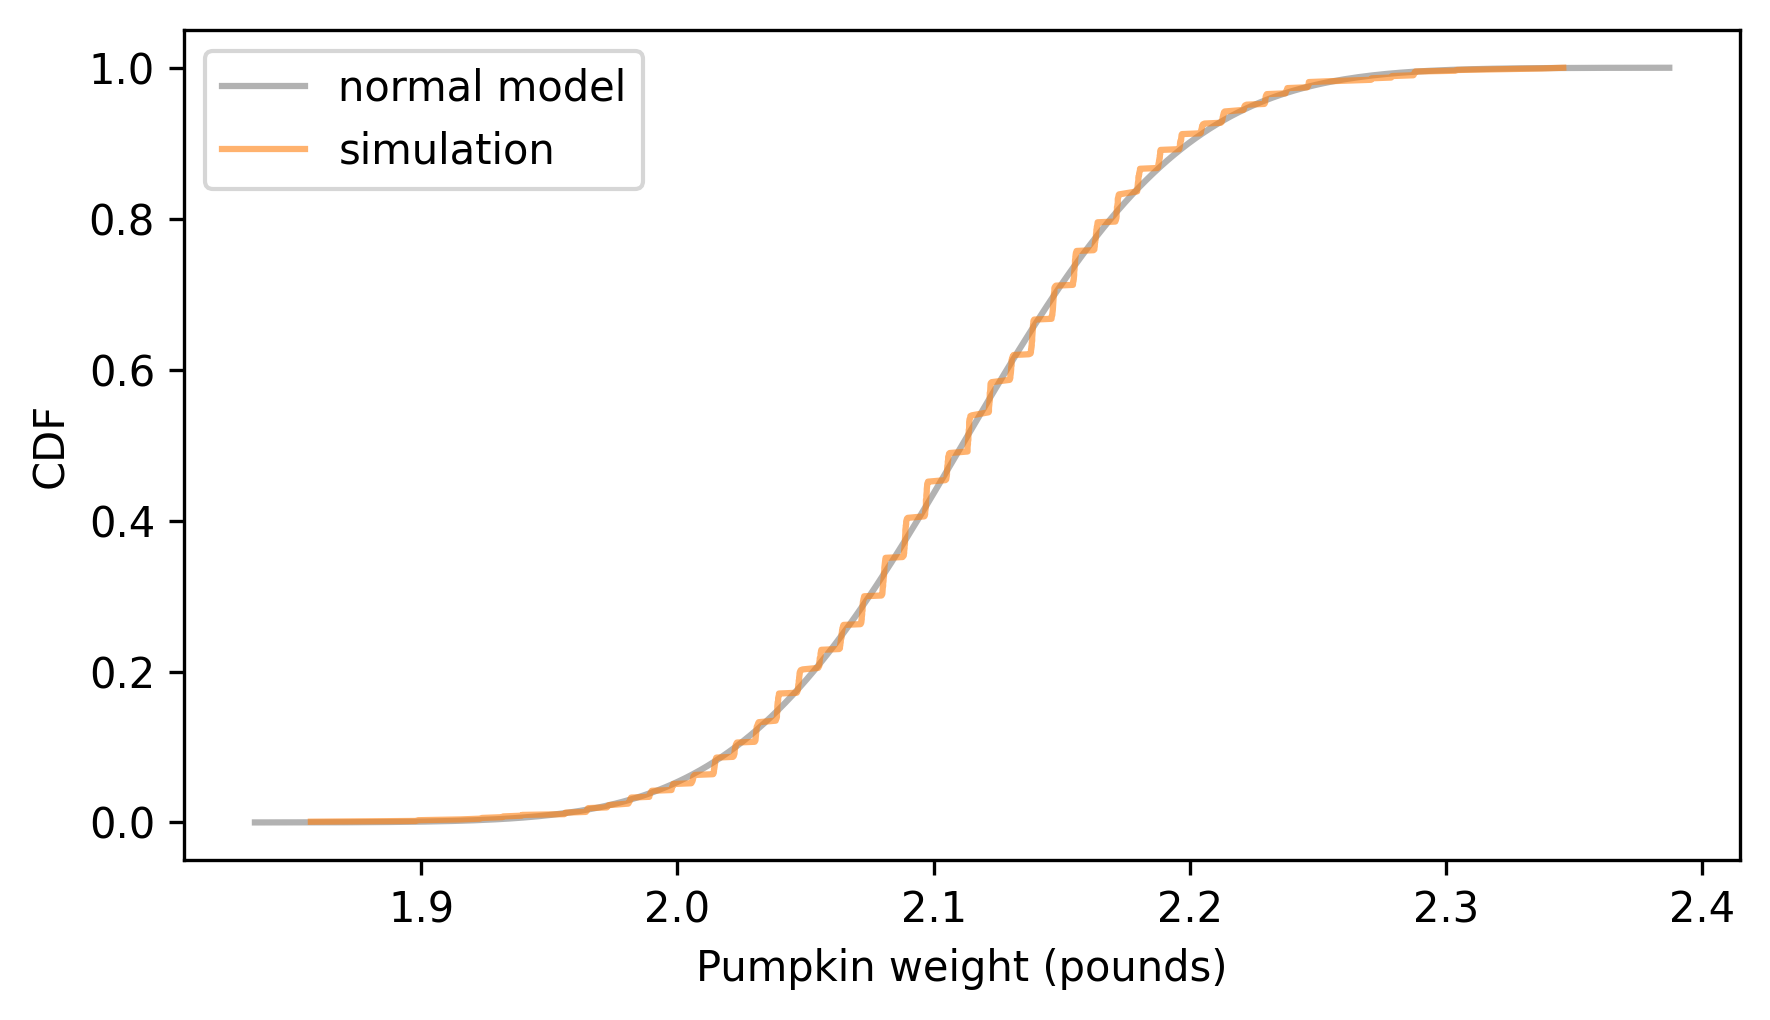

In [73]:
cdf_model = make_normal_model(log_sim_weights)
cdf_log_sim_weights = Cdf.from_seq(log_sim_weights, name="simulation")

two_cdf_plots(
    cdf_model, cdf_log_sim_weights, color="C1", xlabel="Pumpkin weight (pounds)"
)

The model fits the simulation result very well, which is what we expected.

If people are like pumpkins, where the change in weight from year to year is proportionate to their current weight, we might expect the distribution of adult weights to follow a lognormal distribution.
Let's find out.

The National Center for Chronic Disease Prevention and Health Promotion conducts an annual survey as part of the Behavioral Risk Factor Surveillance System (BRFSS).
In 2008, they interviewed 414,509 respondents and asked about their demographics, health, and health risks.
Among the data they collected are the weights in kilograms of 398,484 respondents.
Instructions for downloading the data are in the notebook for this chapter.

In [74]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/CDBRFS08.ASC.gz")

Downloaded CDBRFS08.ASC.gz


The `thinkstats` module provides a function that reads BRFSS data and returns a Pandas `DataFrame`.

In [75]:
from thinkstats import read_brfss

brfss = read_brfss()

Adult weights in kilograms are recorded in the `wtkg2` column.

In [76]:
adult_weights = brfss["wtkg2"].dropna()
m, s = np.mean(adult_weights), np.std(adult_weights)
m, s

(78.9924529968581, 19.54613238740293)

The mean is about 79 kg.
Before we compute logarithms, let's see if the weights follow a normal distribution.

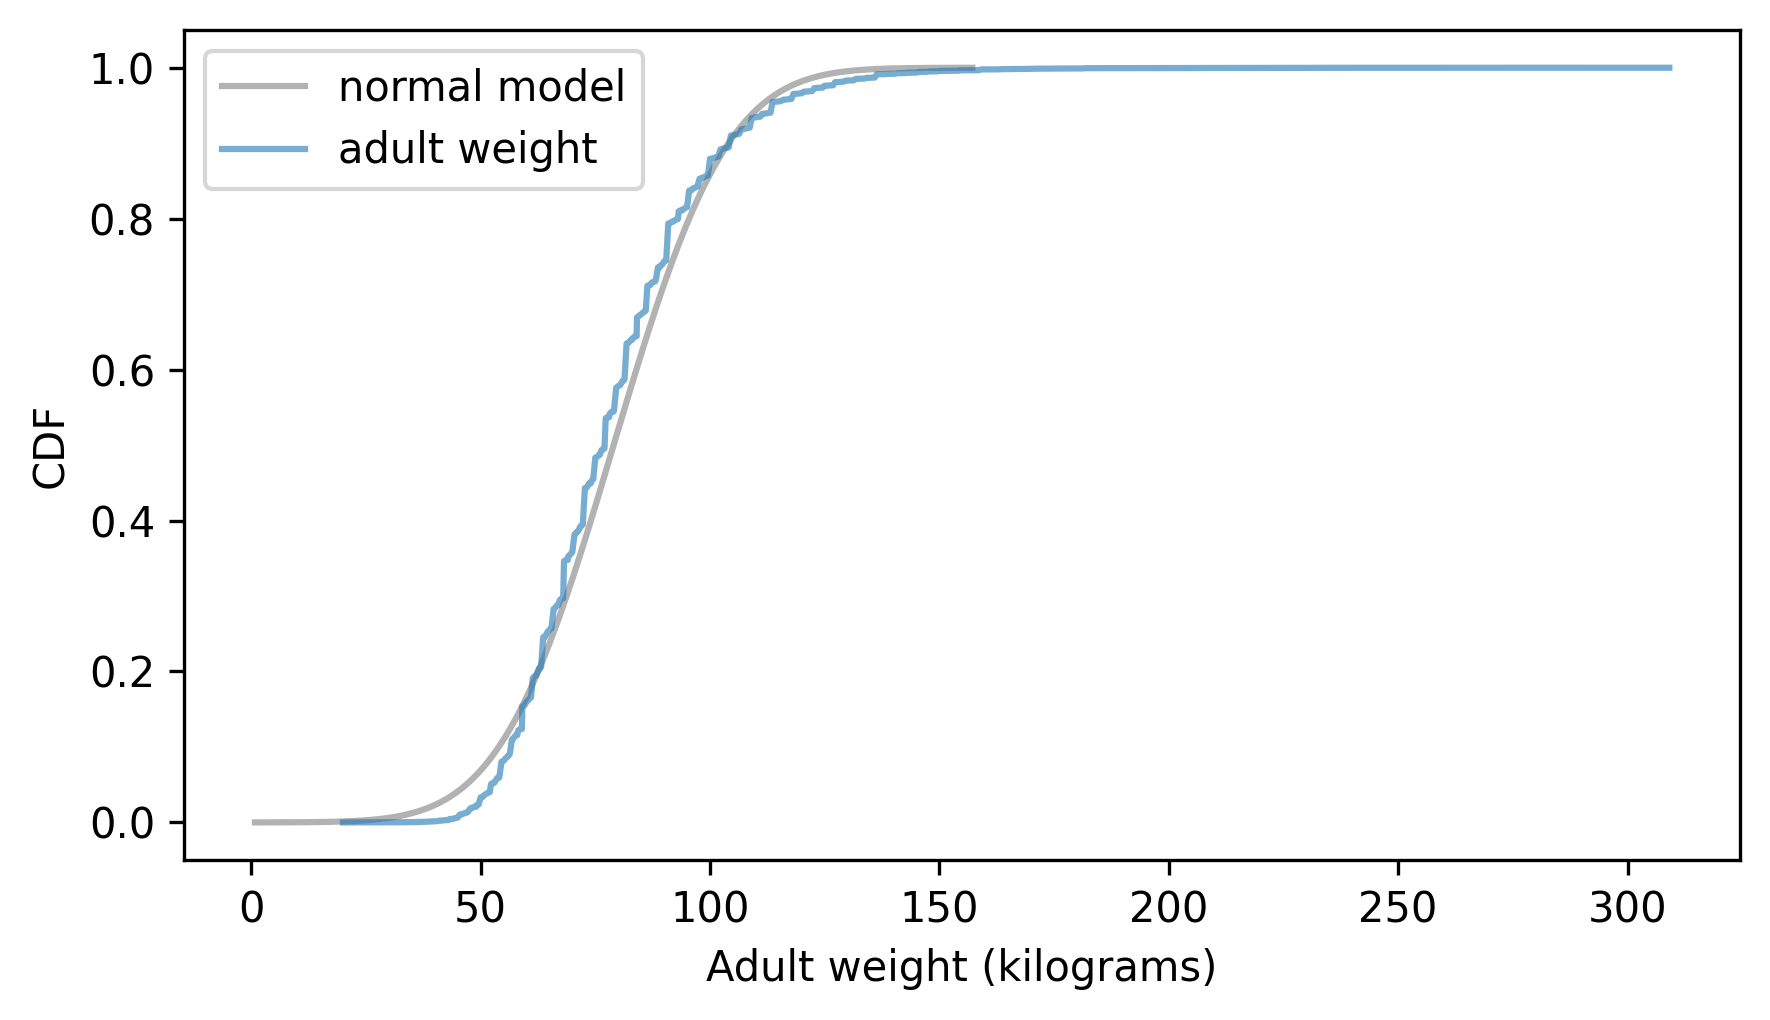

In [77]:
cdf_model = make_normal_model(adult_weights)
cdf_adult_weights = Cdf.from_seq(adult_weights, name="adult weight")

two_cdf_plots(cdf_model, cdf_adult_weights, xlabel="Adult weight (kilograms)")

The normal distribution might be good enough model for this data, for some purposes -- but let's see if we can do better.

Here's the distribution of the log-transformed weights and a normal model with the same mean and standard deviation.

In [78]:
log_adult_weights = np.log10(adult_weights)
cdf_model = make_normal_model(log_adult_weights)

cdf_log_adult_weights = Cdf.from_seq(log_adult_weights, name="log adult weight")

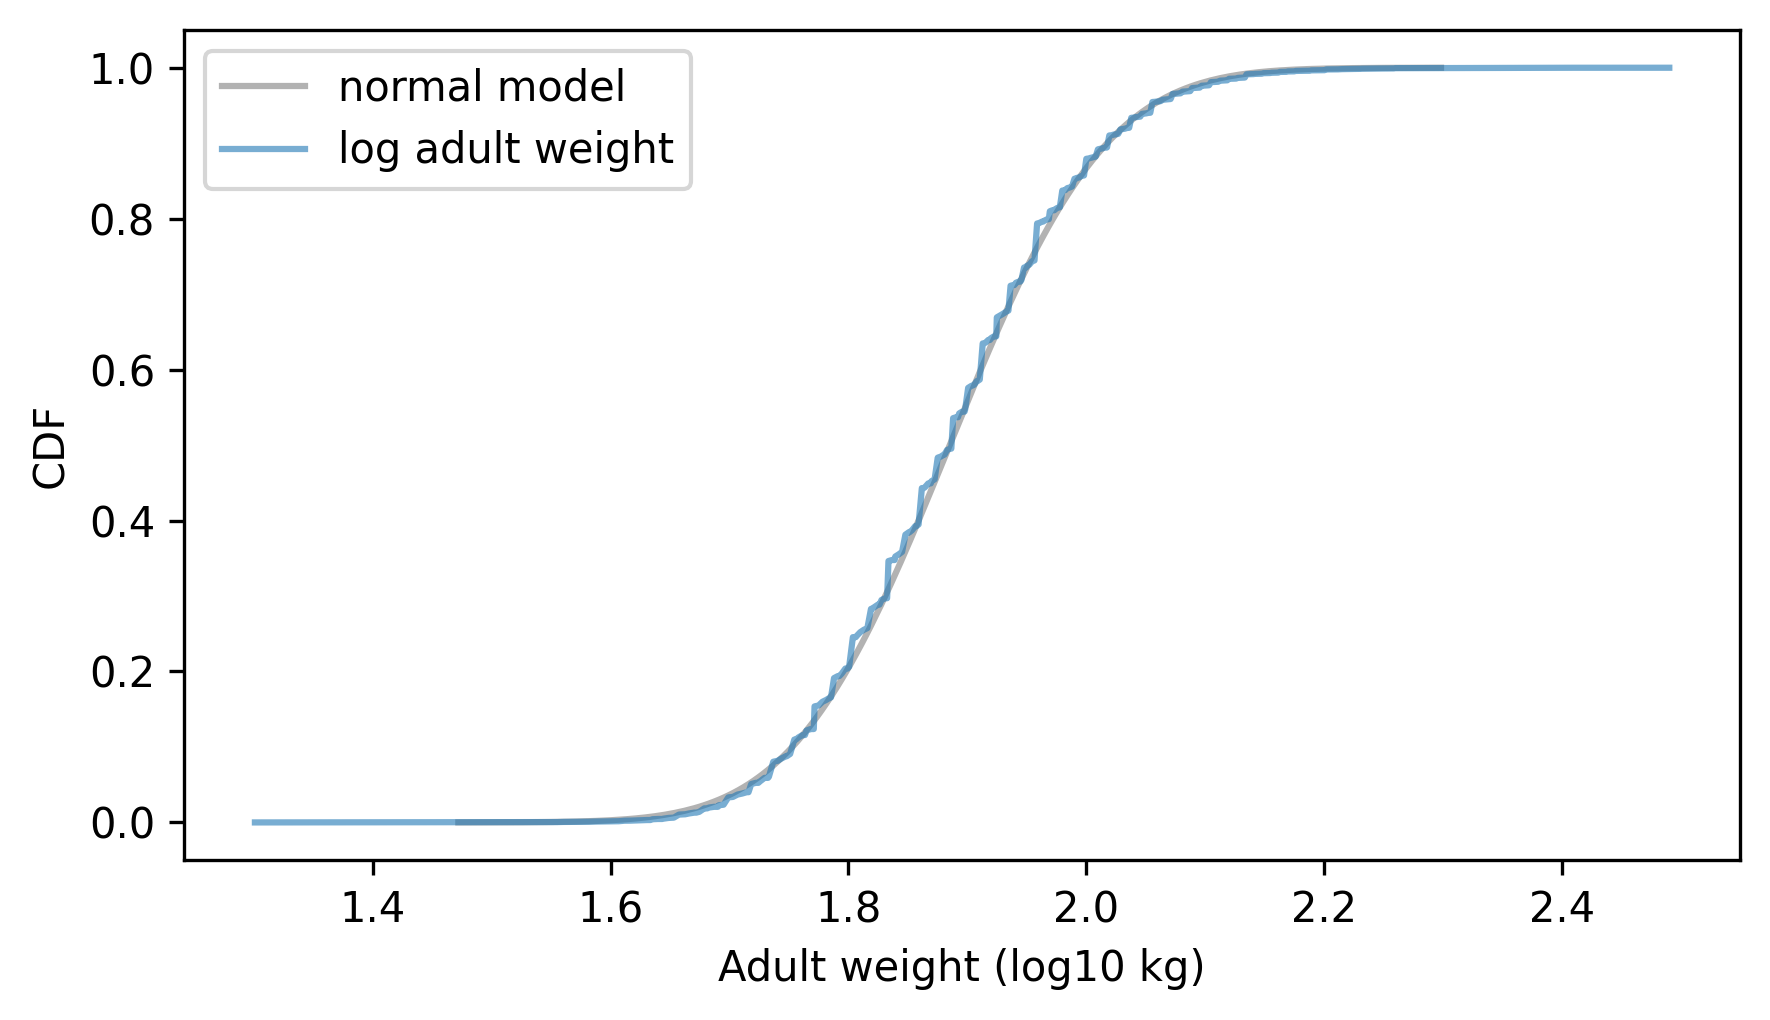

In [79]:
two_cdf_plots(cdf_model, cdf_log_adult_weights, xlabel="Adult weight (log10 kg)")

The normal model fits the logarithms better than it fits the weights themselves, which suggests that proportional growth is a better model of weight gain than additive growth.

## Why model?

At the beginning of this chapter, I said that many real world phenomena can be modeled with theoretical distributions.
But it might not have been clear why we should care.

Like all models, theoretical distributions are abstractions, which means they leave out details that are considered irrelevant.
For example, an observed distribution might have measurement errors or quirks that are specific to the sample; theoretical models ignore these idiosyncrasies.

Theoretical models are also a form of data compression.
When a model fits a dataset well, a small set of parameters can summarize a large amount of data.

It is sometimes surprising when data from a natural phenomenon fit a theoretical distribution, but these observations can provide insight into physical systems.
Sometimes we can explain why an observed distribution has a particular form.
For example, in the previous section we found that adult weight are well-modeled by a lognormal distribution, which suggests that changes in weight from year to year might be proportional to current weight.

Also, theoretical distributions lend themselves to mathematical analysis, as we will see in [Chapter 14](chapter_analytic_methods).

But it is important to remember that all models are imperfect.
Data from the real world never fit a theoretical distribution perfectly.
People sometimes talk as if data are generated by models; for example, they might say that the distribution of human heights is normal, or the distribution of income is lognormal.
Taken literally, these claims cannot be true -- there are always differences between the real world and mathematical models.

Models are useful if they capture the relevant aspects of the real world and leave out unneeded details.
But what is relevant or unneeded depends on what you are planning to use the model for.

## Glossary

- **binomial distribution:** A theoretical distribution often use to model the number of successes or hit in a sequence of hits and misses.

- **Poisson distribution:** A theoretical distribution often used to model the number of events that occur in an interval of time.

- **exponential distribution:** A theoretical distribution often used to model the time between events.

- **normal distribution:** A theoretical distribution often used to model data that follow a symmetric, bell-like curve.

- **lognormal distribution:** A theoretical distribution often used to model data that follow a bell-like curve that is skewed to the right.

## Exercises

### Exercise 5.1

In the NSFG respondent file, the `numfmhh` column records the "number of family members in" each respondent's household.
We can use `read_fem_resp` to read the file, and `query` to select respondents who were 25 or older when they were interviewed.

In [80]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemResp.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemResp.dat.gz")

Downloaded 2002FemResp.dct
Downloaded 2002FemResp.dat.gz


In [81]:
from nsfg import read_fem_resp

resp = read_fem_resp()

In [82]:
older = resp.query("age >= 25")
num_family = older["numfmhh"]

Compute the `Pmf` of `numfmhh` for these older respondents and compare it with a Poisson distribution with the same mean.
How well does the Poisson model fit the data?

<Axes: xlabel='numfmhh'>

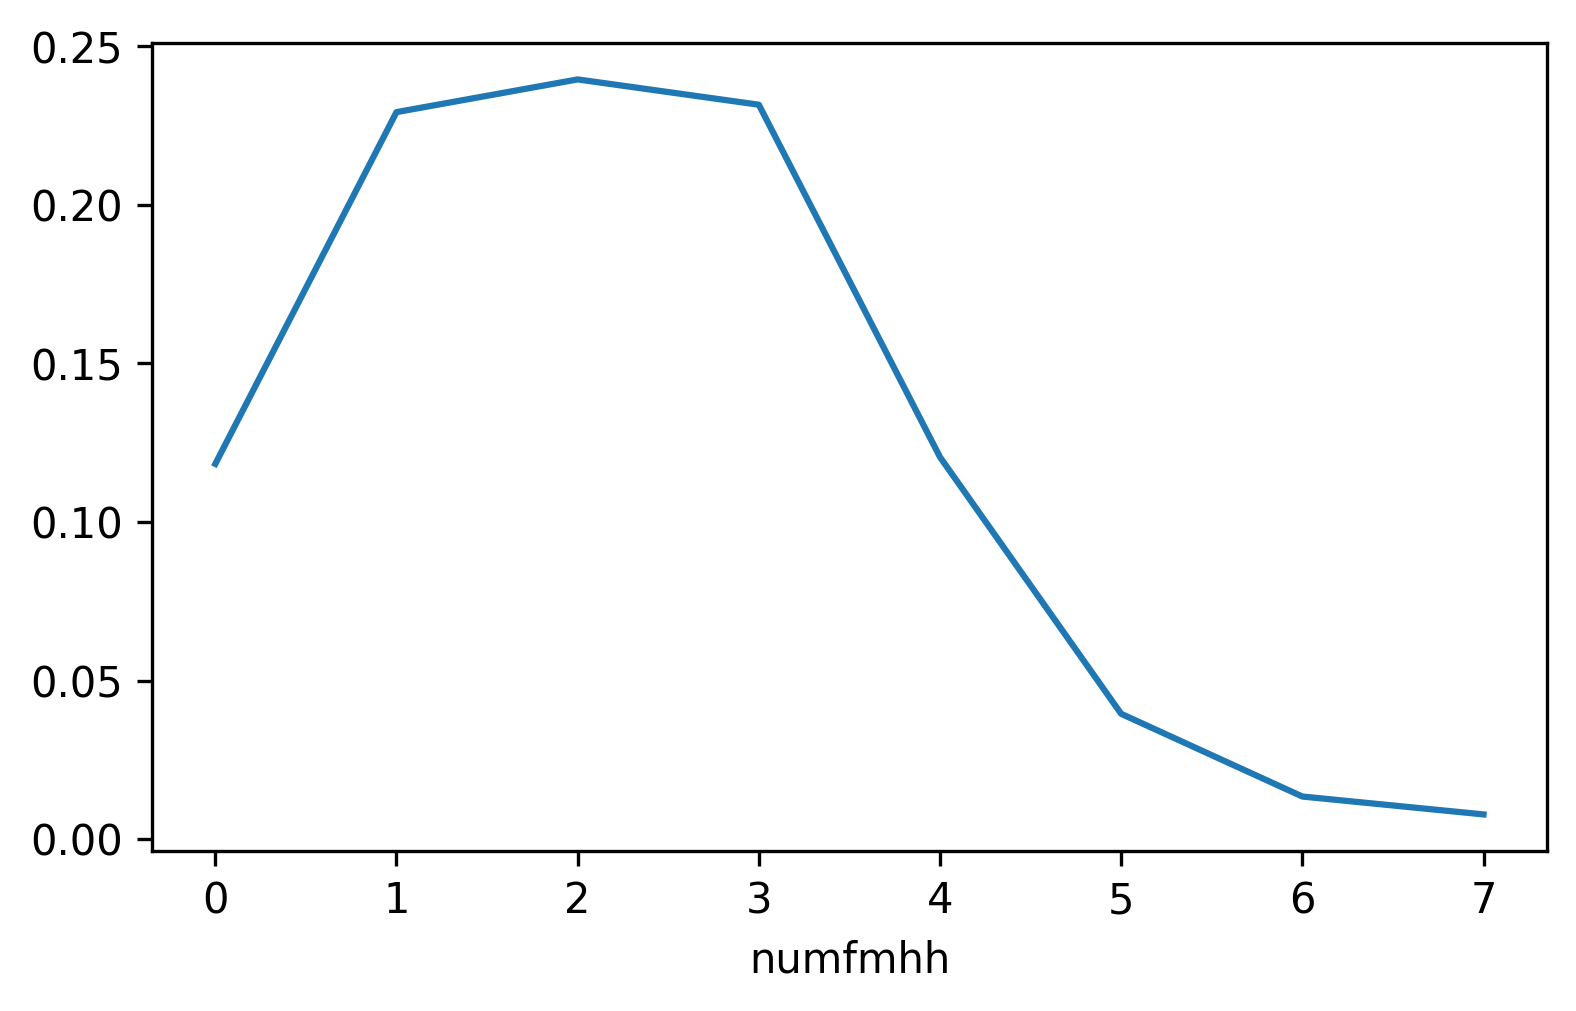

In [83]:
older_pmf = Pmf.from_seq(num_family, name="numfmhh")
older_pmf.plot(label="numfmhh")

<Axes: xlabel='numfmhh'>

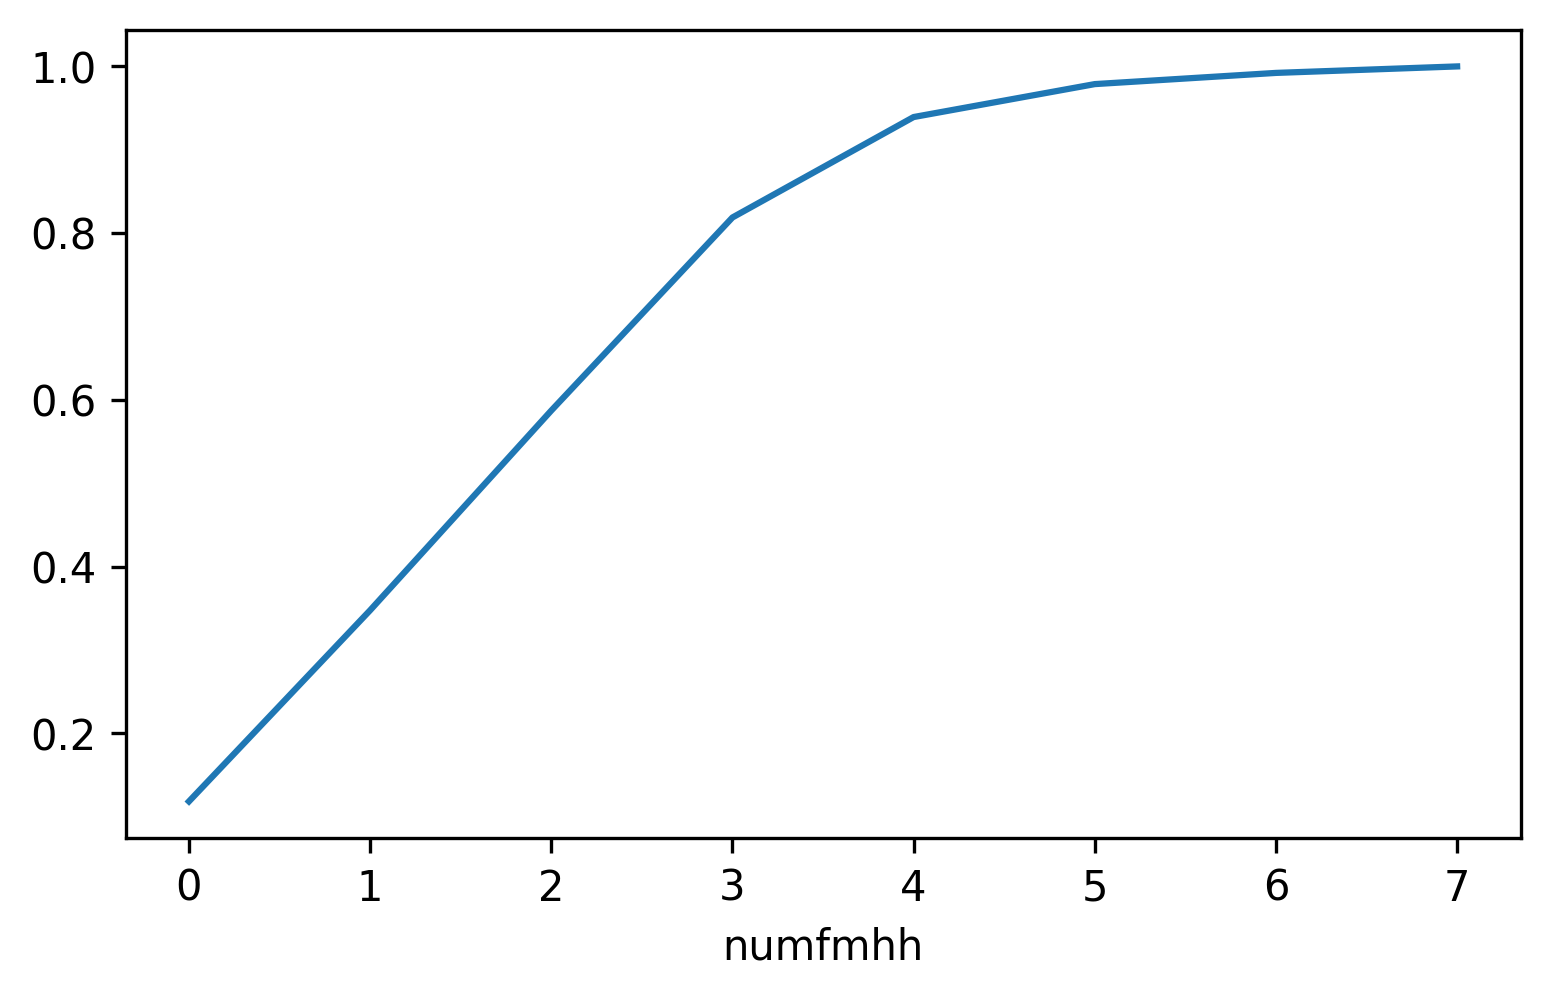

In [84]:
older_cdf = Cdf.from_seq(num_family, name="numfmhh")
older_cdf.plot(label="numfmhh")

In [85]:
older_pmf.mean(), older_pmf.std()

(2.2177890229661346, 1.4607418839607498)

In [104]:
ks = np.arange(0,7)
m = 2.2177890229661346
ps = poisson_pmf(ks, m) # Solution goes here

In [119]:
pmf_poisson = Pmf(ps, ks, name="Poisson model")
ps_cdf = pmf_poisson.make_cdf()

<Axes: >

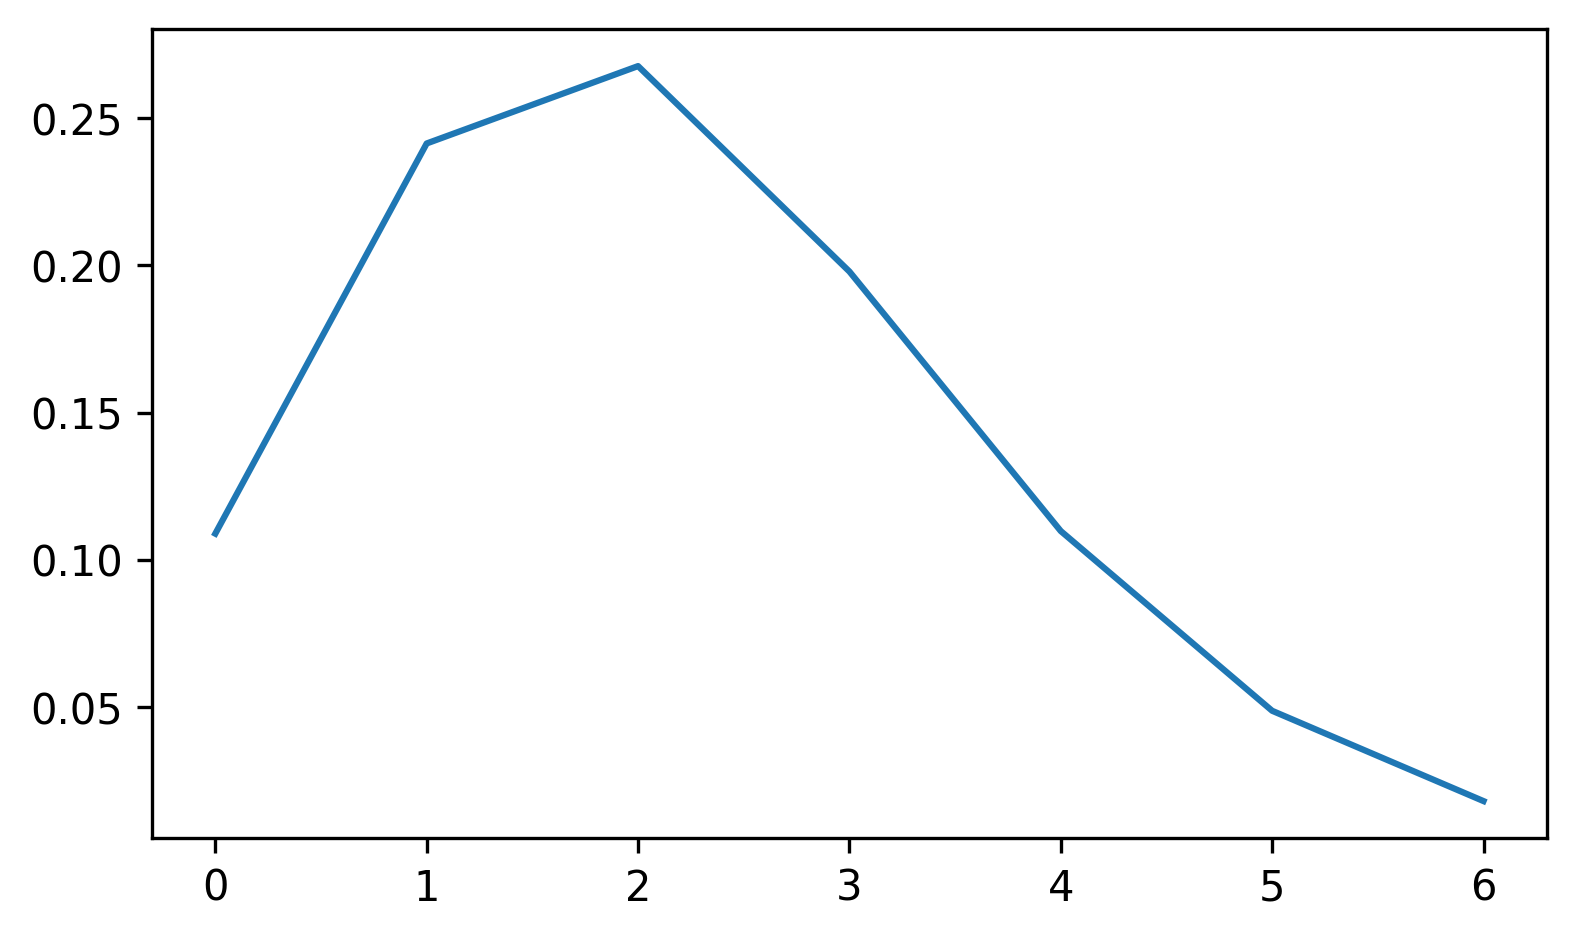

In [121]:
pmf_poisson.plot()

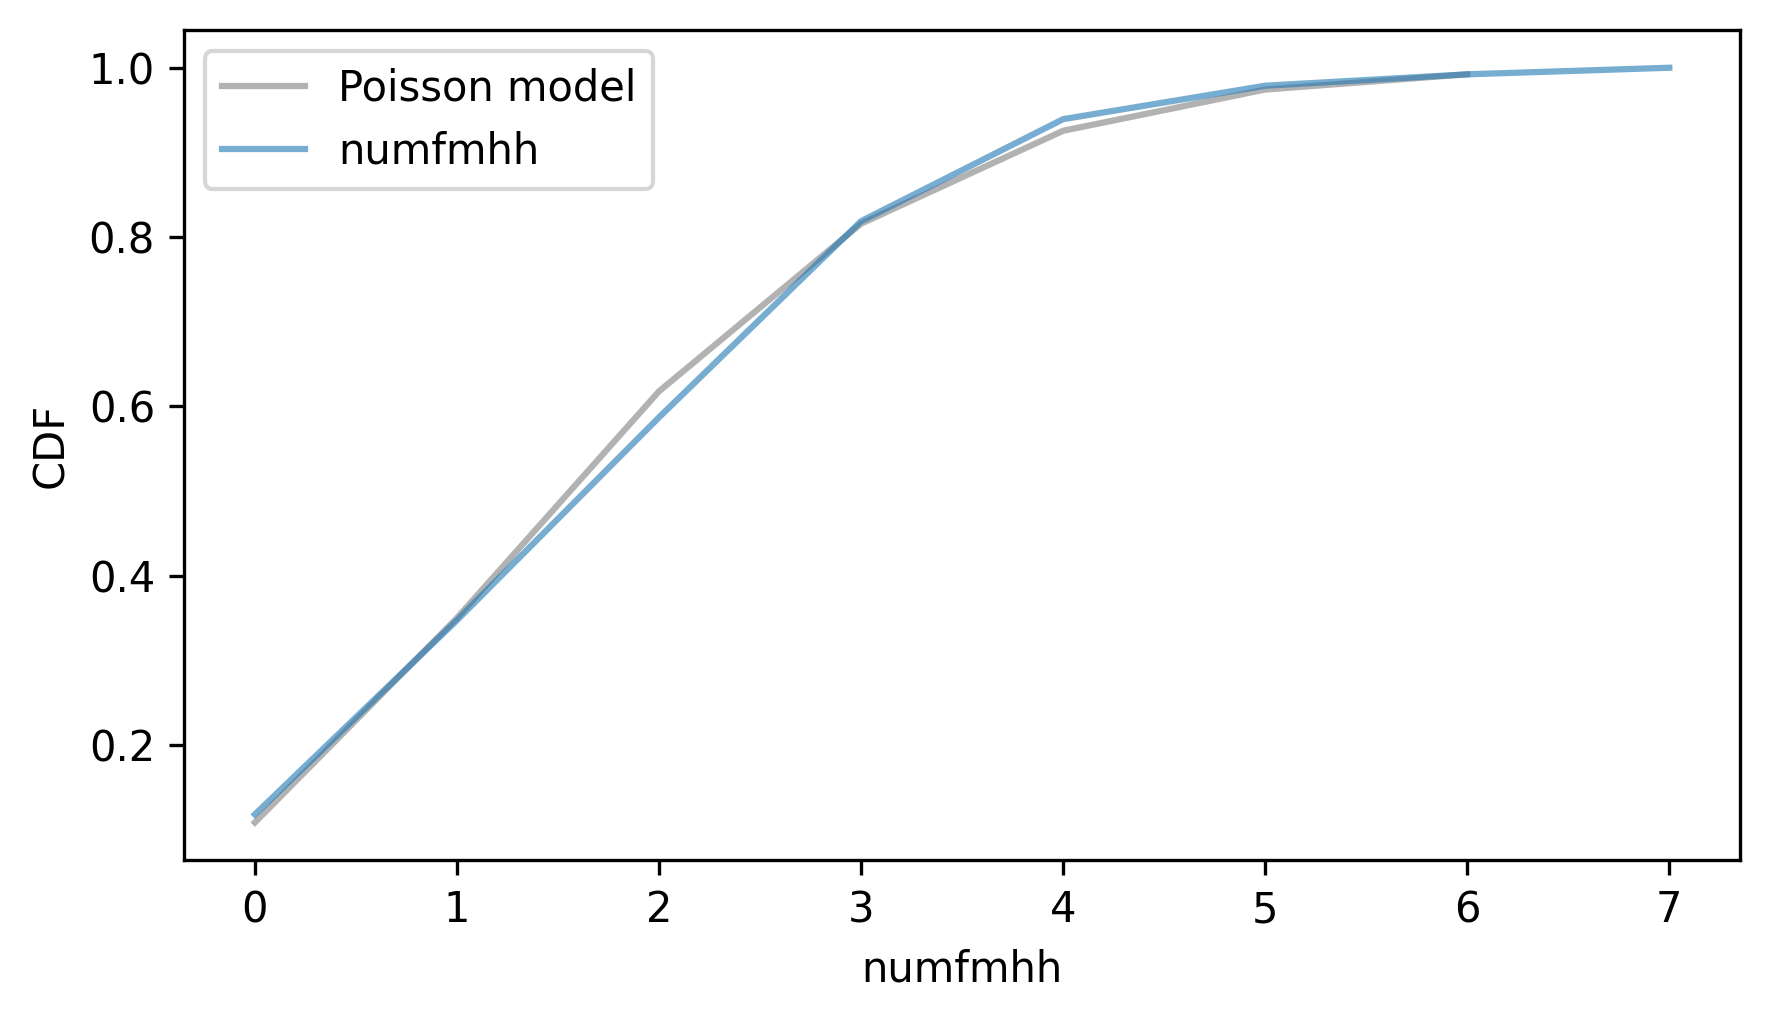

In [120]:
two_cdf_plots(ps_cdf, older_cdf, xlabel="numfmhh")

In [89]:
# Solution goes here

### Exercise 5.2

Earlier in this chapter we saw that the time until the first goal in a hockey game follows an exponential distribution.
If our model of goal-scoring is correct, a goal is equally likely at any time, regardless of how long it has been since the previous goal.
And if that's true, we expect the time between goals to follow an exponential distribution.

The following loop reads the hockey data again, computes the time between successive goals, if there is more than one in a game, and collects the inter-goal times in a list.

In [122]:
filename = "nhl_2023_2024.hdf"

with pd.HDFStore(filename, "r") as store:
    keys = store.keys()

In [91]:
intervals = []

for key in keys:
    times = pd.read_hdf(filename, key=key)
    if len(times) > 1:
        intervals.extend(times.diff().dropna())

In [130]:
intervals_np = np.array(intervals)
intervals_np.mean(), intervals_np.std(), intervals_np.max(), intervals_np.min()

(489.9951419462578, 446.72041737048977, 3007.0, 4.0)

In [129]:
intervals_pmf = Pmf.from_seq(intervals, name="data")
intervals_pmf.mean(), intervals_pmf.std()

(489.9951419462578,
 446.7204173704897,
 0.002884469409442842,
 0.0001518141794443601)

In [134]:
m = intervals_pmf.mean()
lam = 1/m

ts = np.linspace(4, 3007, 201)
ps = exponential_cdf(ts, lam)


<Axes: >

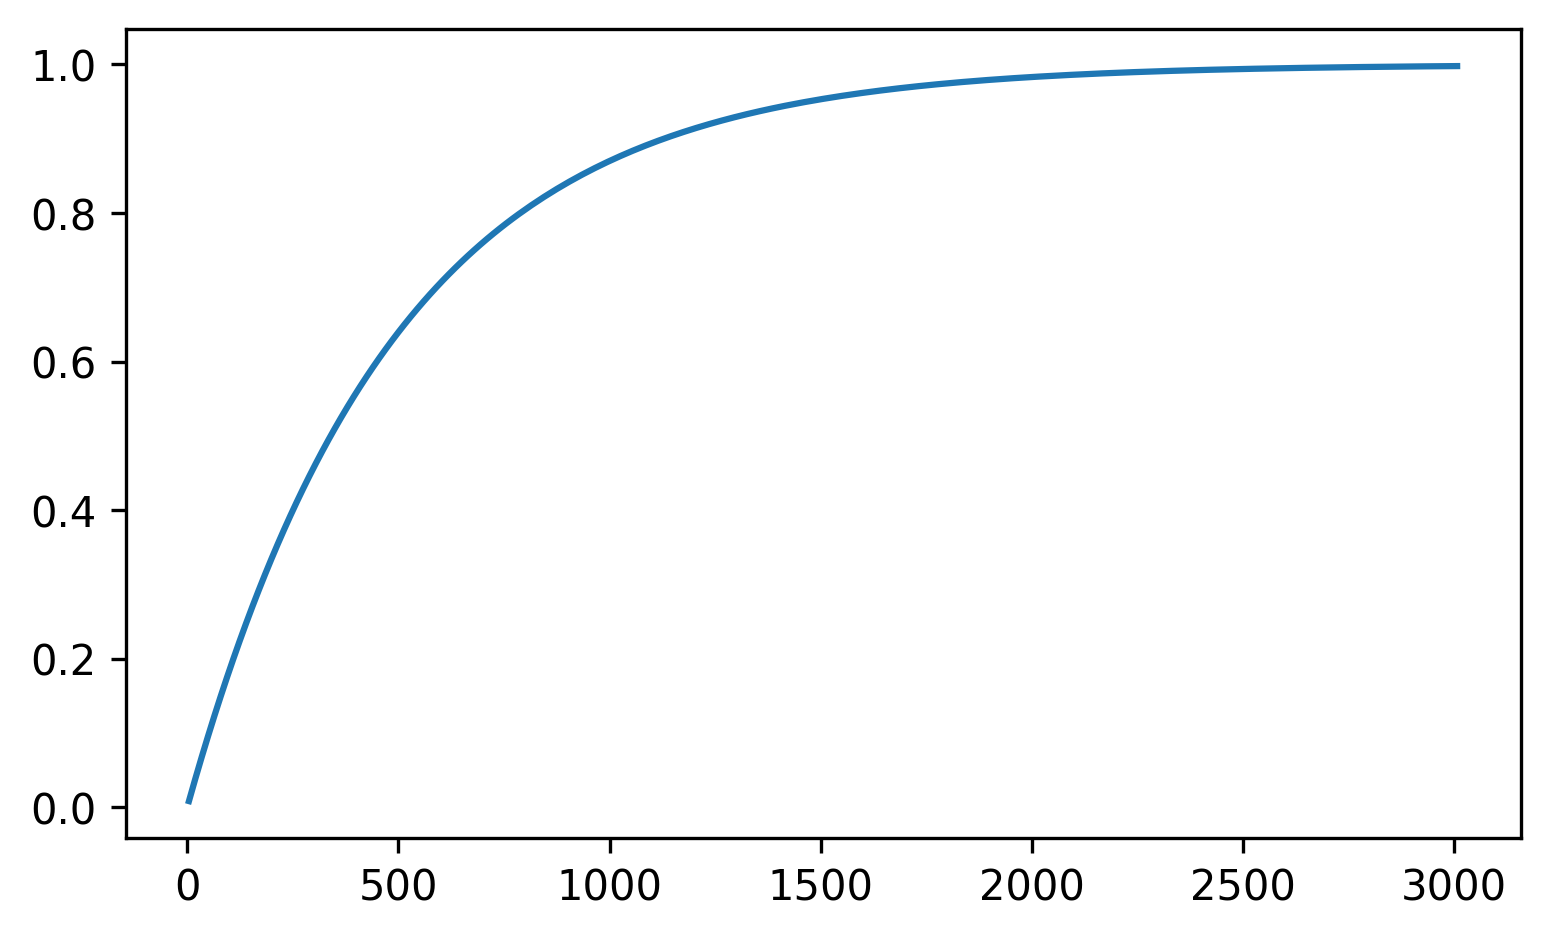

In [138]:
ecdf = Cdf(ps, ts, name="exponential model")
ecdf.plot()

Use `exponential_cdf` to compute the CDF of an exponential distribution with the same mean as the observed intervals and compare this model to the CDF of the data.

<Axes: >

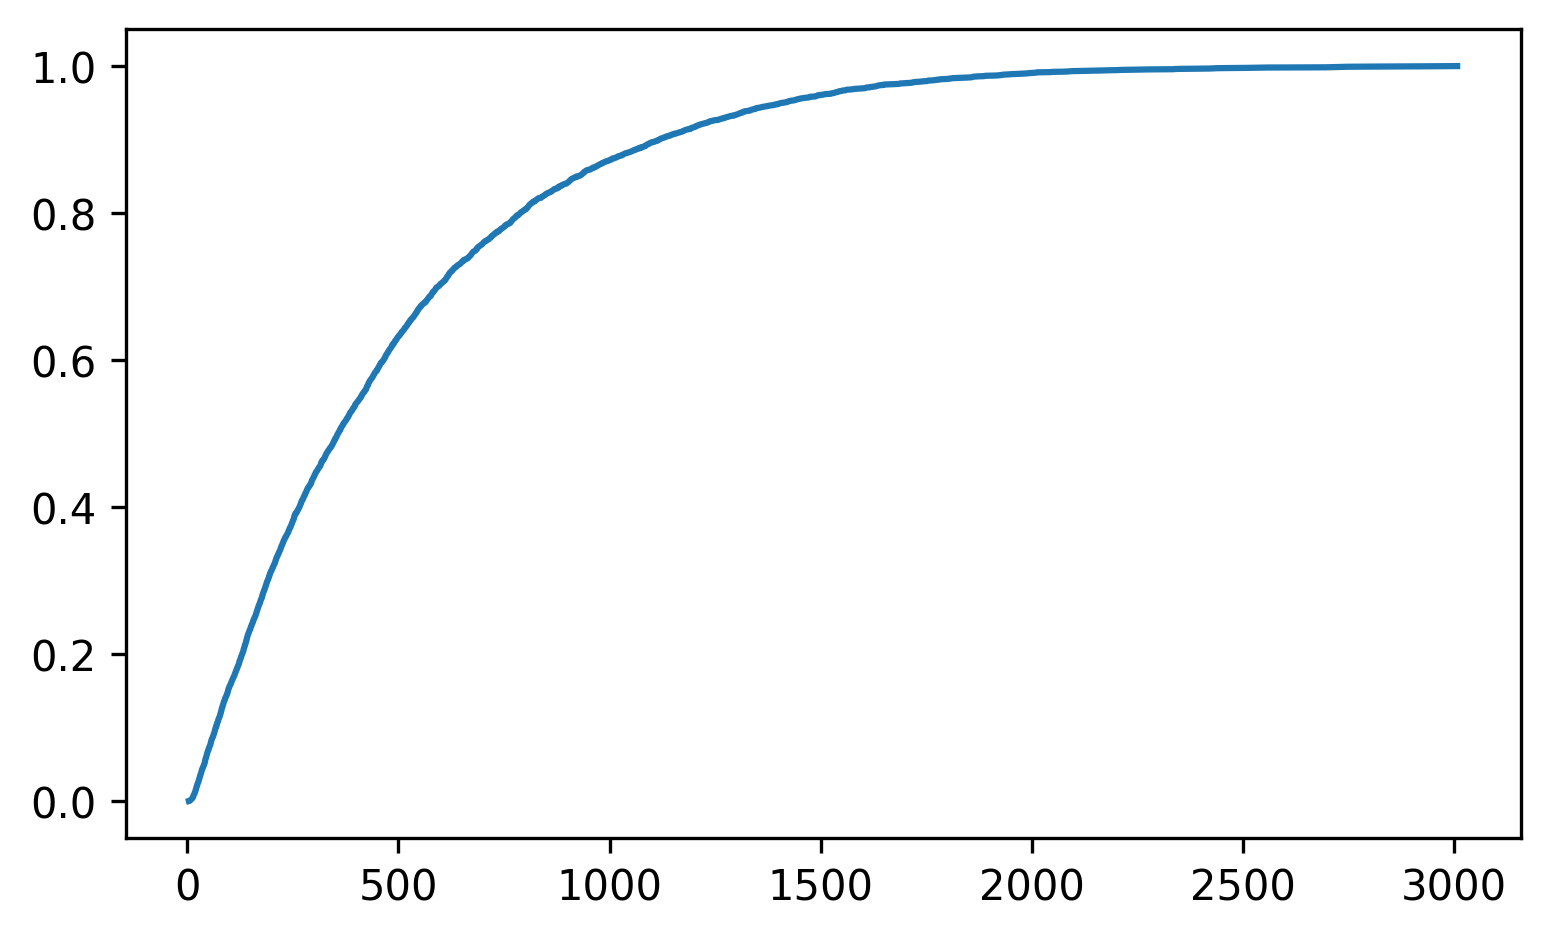

In [124]:
intervals_cdf = Cdf.from_seq(intervals, name="data")
intervals_cdf.plot()

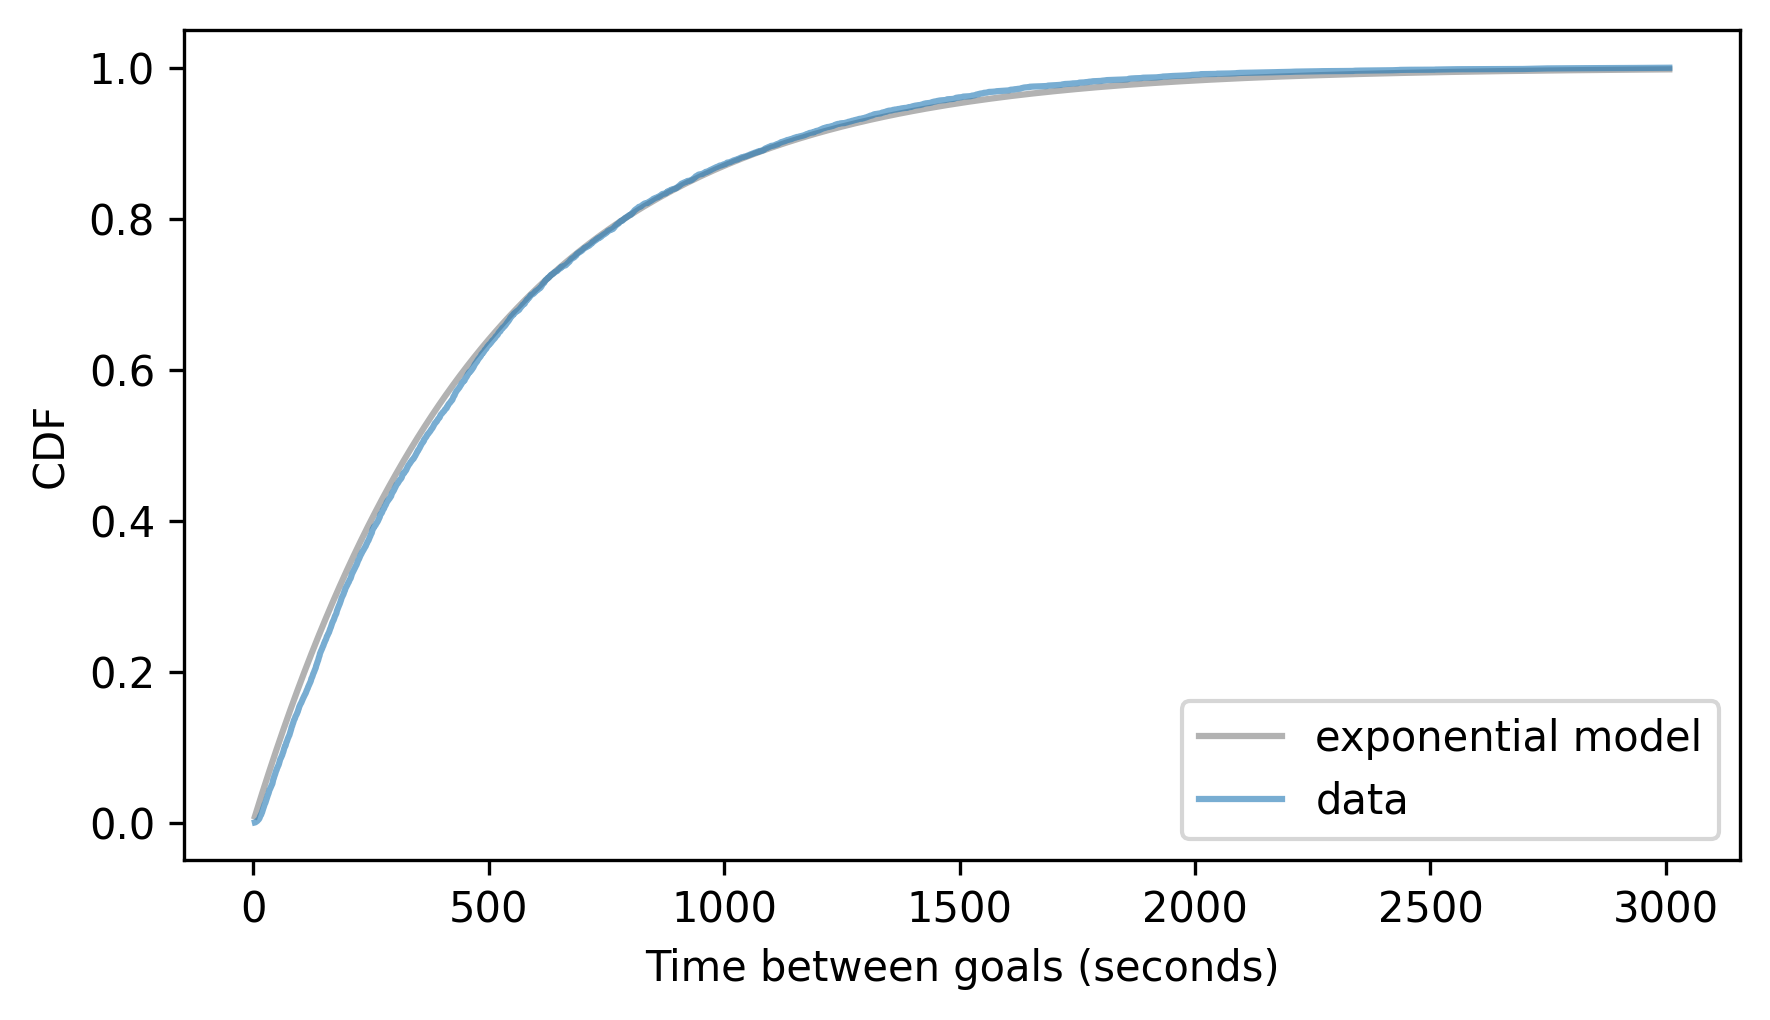

In [139]:
two_cdf_plots(ecdf, intervals_cdf, xlabel="Time between goals (seconds)")

In [94]:
# Solution goes here

In [95]:
# Solution goes here

In [96]:
# Solution goes here

### Exercise 5.3

Is the distribution of human height more like a normal or a lognormal distribution?
To find out, we can select height data from the BRFSS like this:

In [140]:
adult_heights = brfss["htm3"].dropna()
m, s = np.mean(adult_heights), np.std(adult_heights)
m, s

(168.82518961012298, 10.352640156457166)

Compute the CDF of these values and compare it to a normal distribution with the same mean and standard deviation.
Then compute the logarithms of the heights and compute the distribution of the logarithms to a normal distribution.
Which model fits the data better?

<Axes: xlabel='htm3'>

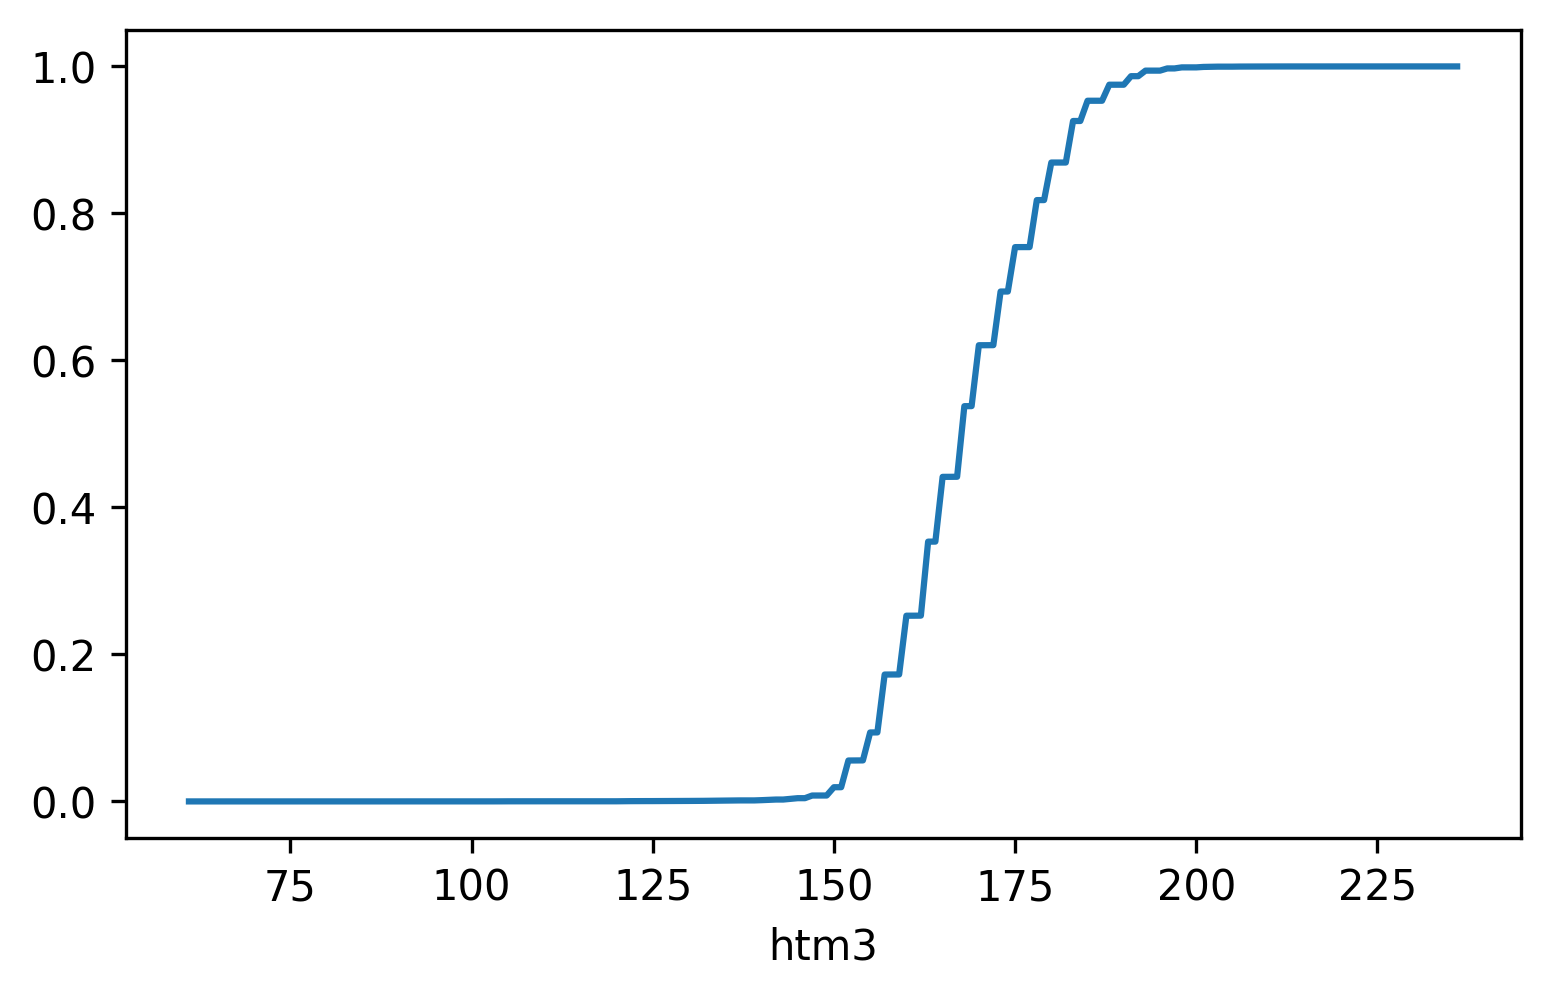

In [141]:
h_cdf = Cdf.from_seq(adult_heights, name="adult height")
h_cdf.plot()

In [142]:
h_normal_cdf = make_normal_model(adult_heights)

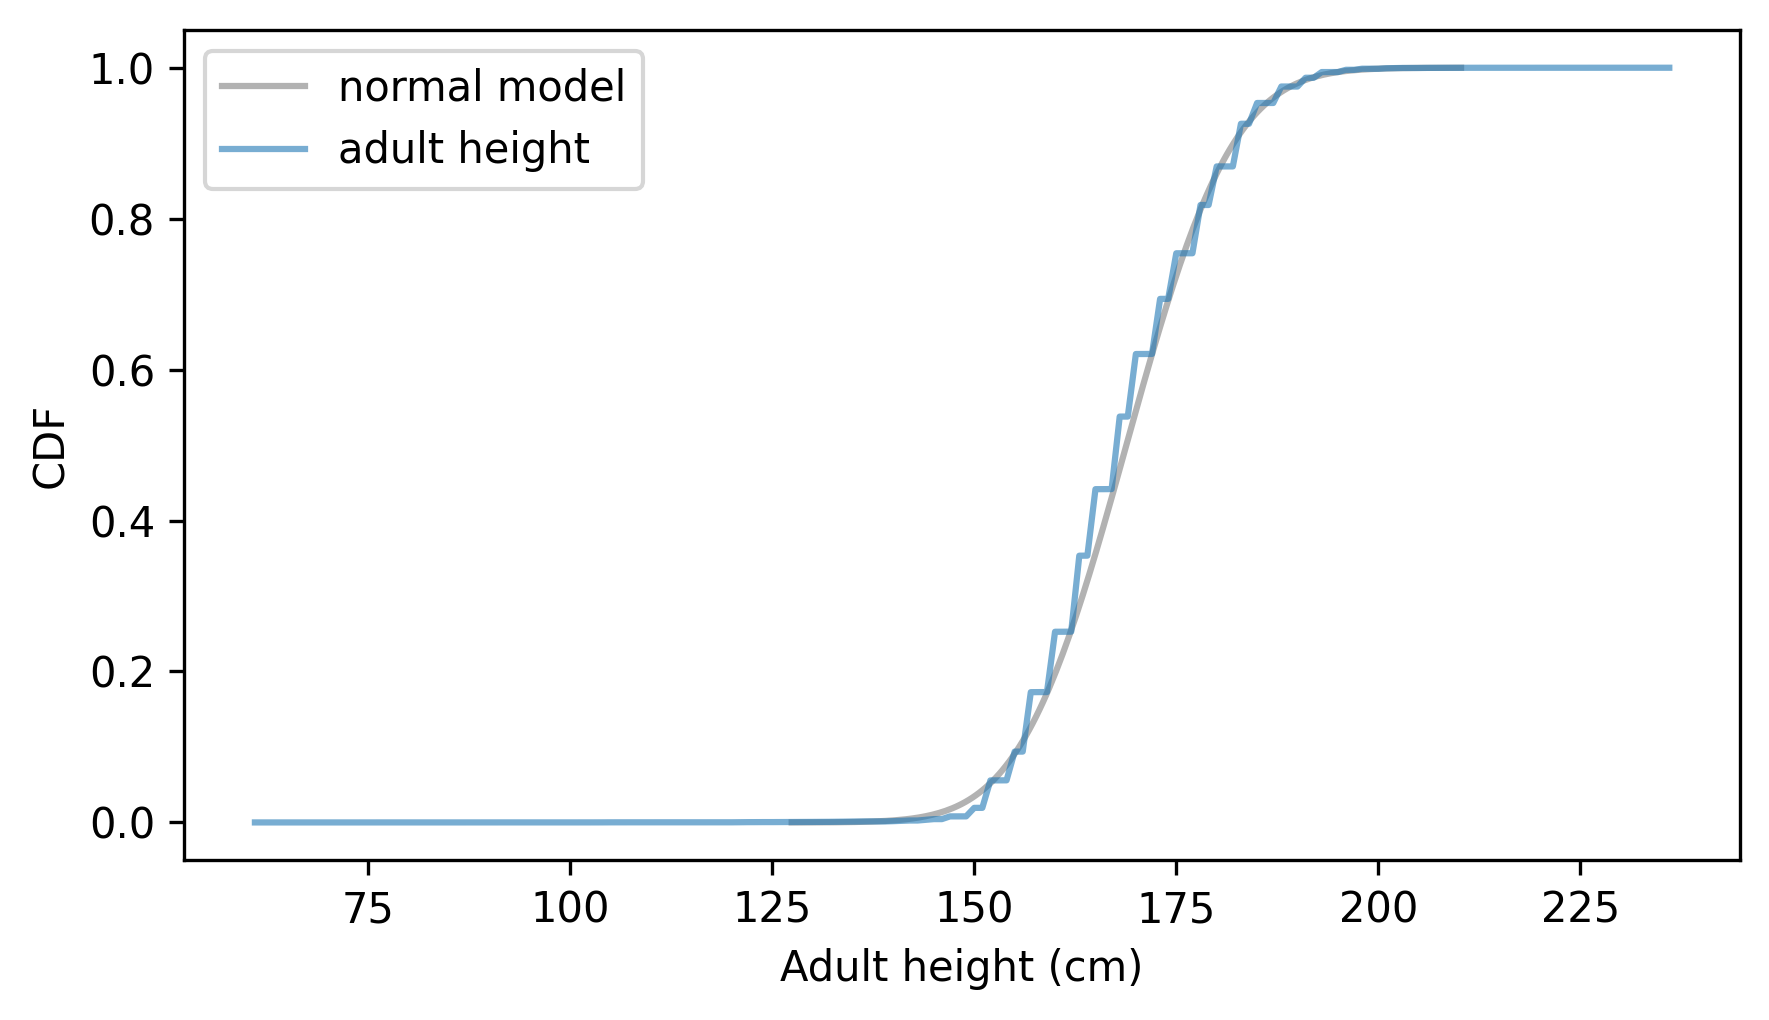

In [143]:
two_cdf_plots(h_normal_cdf, h_cdf, xlabel="Adult height (cm)")

In [145]:
hlog_ad = np.log10(adult_heights)

In [153]:
hlog_cdf = Cdf.from_seq(hlog_ad)

In [146]:
log_n_cdf = make_normal_model(hlog_ad) # Solution goes here

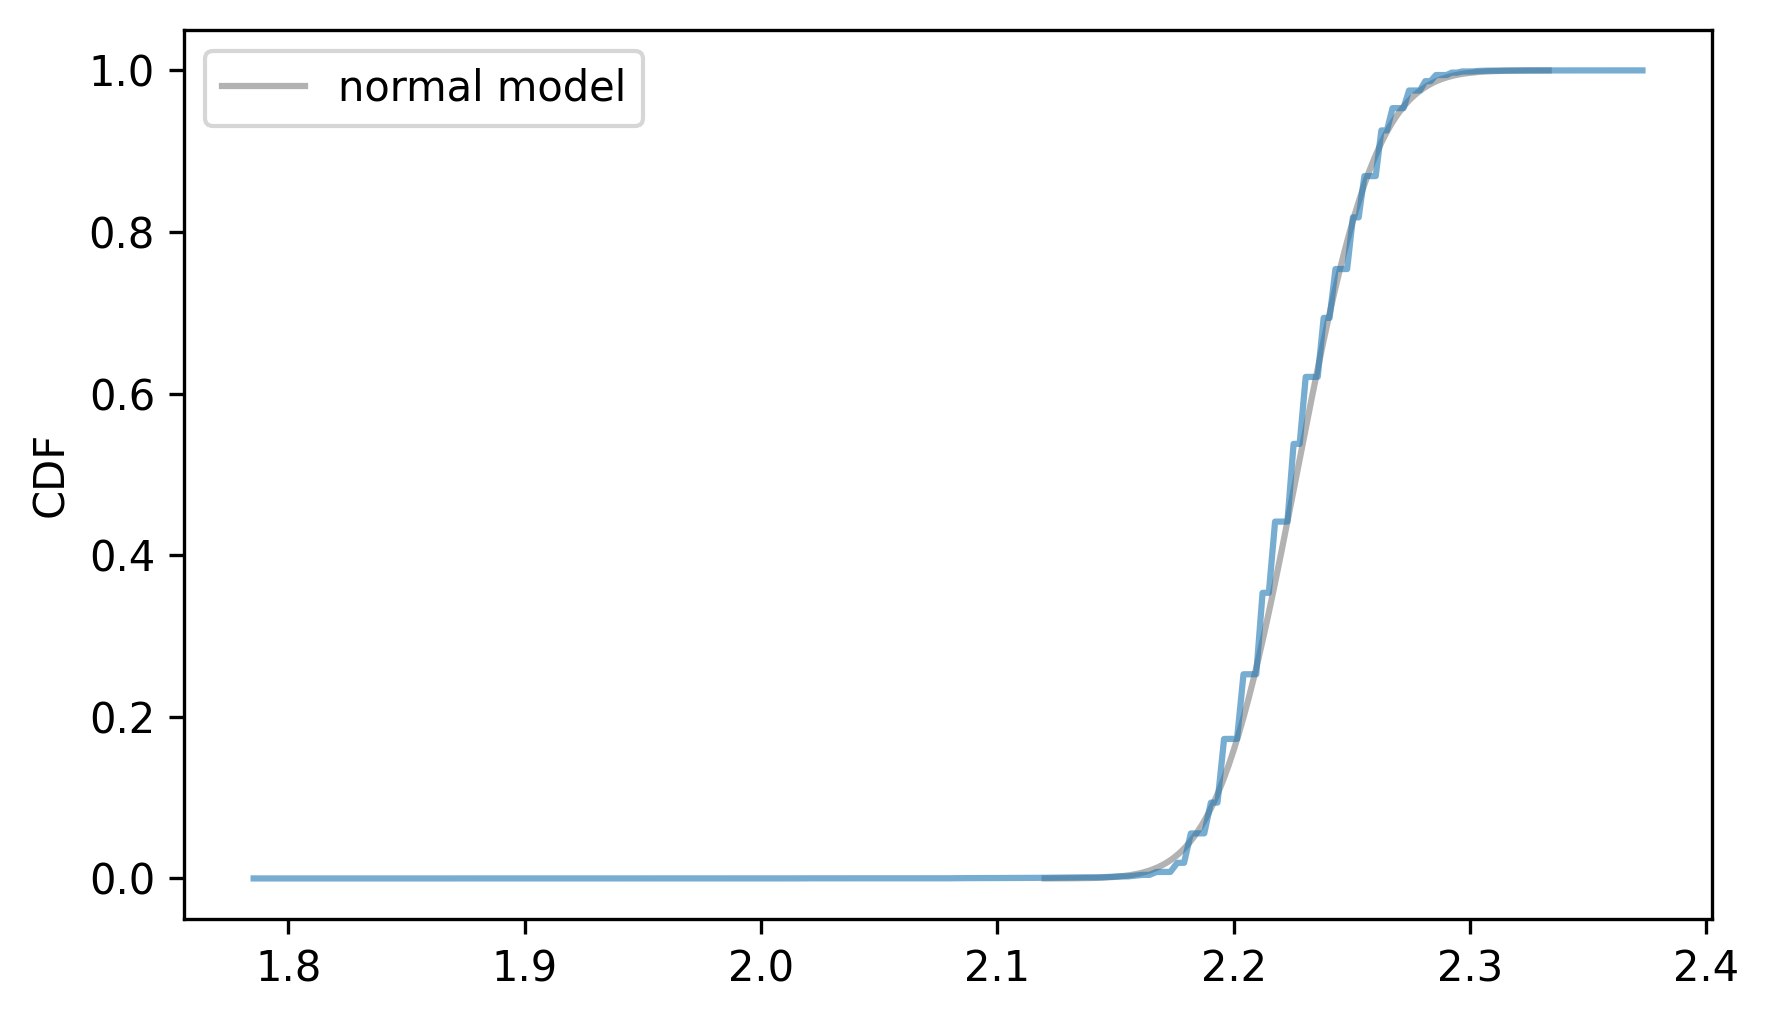

In [156]:
two_cdf_plots(log_n_cdf, hlog_cdf)  # Solution goes here

[Think Stats: Exploratory Data Analysis in Python, 3rd Edition](https://allendowney.github.io/ThinkStats/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)